# VAE training and pre-processing

In [1]:
import os
import math
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import heapq
import cmath
import warnings
import tensorflow as tf
import tf_keras
import keras
import tensorflow.keras.backend as K

from enum import Enum
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from collections import Counter
from scipy.cluster import vq
from scipy.stats import dirichlet


random_state = 42
random.seed(random_state)
np.random.seed(random_state) # predictable random numbers, for demonstration only
tf.random.set_seed(random_state) # reproducibility
os.environ['PYTHONHASHSEED'] = str(random_state) # reproducibility
os.environ['TF_DETERMINISTIC_OPS'] = '1' # make operations deterministic
os.environ["TF_USE_LEGACY_KERAS"]= '1' # Use legacy keras for compatibility
warnings.filterwarnings("ignore")

In [2]:
class Compression_Method(Enum):
    XY = 1               #applies PCA on X and Y then filters (1)
    AmpPhase = 2         #applies PCA on Amplitude and Phase then filters (2)
    AmpPhaseFiltered = 3 #applies PCA on Amplitude and Phase after filtering (3)

#Modify this to change the approach used: XY, AmpPhase, AmpPhaseFiltered
method = Compression_Method.AmpPhase
scaler = StandardScaler()
ignorePhases = True
saveCSV = True

latent_dim = 1 
num_activities = 2 #present or absent

folder_name = 'vae_weights'
models_directory = './models'
results_directory = './results'
os.makedirs(os.path.join(models_directory, folder_name), exist_ok=True)

## Variables and Functions definitions

In [3]:
notInterestedIndexes = list(range(-32,-28)) + list(range(0,1)) + list(range(29,32)) #null columns in the dataset
interestedIndexes = list(range(-28,0)) + list(range(1,29)) #non null columns in the dataset

w1=5 #for filtering
w2=3 #for windows
#w2=1 #1 second per window
lambda1=3 #threshold

#build ground truth
t2 = 1205
lb1 = [120,360,600,900]
ub1 = [240,480,720,1080]
lb2 = [t2+l for l in [180,540,990,1500]]
ub2 = [t2+u for u in [360,750,1170,1590]]

lower_bounds = lb1+lb2
upper_bounds = ub1+ub2

In [4]:
def getGT(timestamp,lower_bounds,upper_bounds):
    # if I'm in the room in one case, or I'm crossing the entrance put 1
    for i in range (0, len(lower_bounds)):
        if (timestamp >= lower_bounds[i]) & (timestamp <= upper_bounds[i]):
            return 1
    return 0

def classify_presence(df, ycol="MuStdAmplPaper", plot_roc=False, num_iter=1000, thr=None):
    # Y are the labels that indicate if i'm passing or not
    Y = df["Label"]
    # thr is the threshold: if amplitude > thr, then assign to Y_pred 1 (presence), otherwise 0. Every time update the threshold
    if thr is None:
        thr= df[ycol].min()
        tpr = []
        fpr= []
        thr_list= []
        step = (df[ycol].max() - df[ycol].min()) / num_iter
        while thr <= df[ycol].max():
            # compute the predictions
            Y_pred = df.apply(lambda row: 1 if row[ycol] >= thr else 0, axis=1)
            tn, fp, fn, tp = confusion_matrix(Y, Y_pred).ravel()
            # compute True Positive Rate and False Positive rate to plot the roc curve
            tpr.append(tp/(tp+fn))
            fpr.append(fp/(fp+tn))
            thr_list.append(thr)
            thr += step
        thr = select_threshold(thr_list, df, ycol) # select the threshold that maximizes the f1 score for class 

    if plot_roc:
        plt.figure(figsize=(3,3),dpi=220)
        plt.plot(fpr, tpr)
        plt.plot([0, 1], [0, 1], color = 'green')
        plt.xlim(-0.05, 1.05)
        plt.ylim(-0.05, 1.05)
        plt.grid()
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC curve")
        plt.show()

    Y_pred_final = (df[ycol] >= thr).astype(int)
    f1_result = compute_f1(Y, Y_pred_final)
    print(classification_report(Y, Y_pred_final, target_names=["absent", "present"]))
    #accuracy = accuracy_score(Y, Y_pred)

    return f1_result, thr

def compute_f1(Y, Y_pred, label=1):
    precision = precision_score(Y, Y_pred, pos_label=label)
    recall = recall_score(Y, Y_pred, pos_label=label)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
    return f1

def select_threshold(thr_list, df, ycol, label=1):
    # compute the f1 score for class 1
    Y = df["Label"]
    f1_scores_class_1 = []
    for thr in thr_list:
        Y_pred = (df[ycol] >= thr).astype(int)
        f1_class_1 = compute_f1(Y, Y_pred, label)
        f1_scores_class_1.append(f1_class_1)

    # find the optimal threshold for class 1
    optimal_idx = np.argmax(f1_scores_class_1)
    optimal_thr = thr_list[optimal_idx]

    return optimal_thr

def extractWindowedFeatures(data, column_indexes = [], w2=3):
    data["TimeWindow"] = np.floor(data["Timestamp"] / w2)*w2
    #vertical mean/std
    dataStd = data.groupby(by="TimeWindow").std().drop(["Timestamp","Frame_num"],axis=1)
    #dataMean = data.groupby(by="TimeWindow").mean().drop(["Timestamp","Frame_num"],axis=1)
    
    featuredDf = pd.DataFrame()
    featuredDf["Time"] = data["TimeWindow"].unique()
    #horizontal
    featuredDf["MuStdAmplPaper"] = dataStd[[j for j in column_indexes if j.startswith('Ampl')]].mean(axis=1).reset_index(drop=True) #Axis=1: mean over different columns -> into one col
    return featuredDf

#removes outliers from the data
def filterData(df,w1=3,lambda1=3):
    data = df.copy()
    col_list = [j for j in data.columns if "Ampl" in j]

    for index, row in data.iterrows():
        if index == 0:
            prev_row = row
            continue
        if (index%10000 == 0): print(index)
        subDf = data.loc[(data["Timestamp"]<=row['Timestamp']) & (data["Timestamp"]> row['Timestamp'] - w1),col_list]
        means = subDf.mean(axis=0)
        stds = subDf.std(axis=0)

        for c in col_list: 
            if (abs(row[c] - means[c]) / stds[c]) > lambda1:
                data.at[index,c] = prev_row[c]
                #row[c] = prev_row[c]

        prev_row = row
    return data

def filterData2(df, w1=3, lambda1=3):
    data = df.copy()
    col_list = [j for j in data.columns if "Ampl" in j]
    
    # Rolling window to calculate means and std deviations, shifted to exclude the current row
    rolling_means = data[col_list].rolling(window=w1, min_periods=1).mean().shift(1)
    rolling_stds = data[col_list].rolling(window=w1, min_periods=1).std().shift(1)

    # Start at second row since the first row is skipped in original logic
    for index in range(1, len(data)):
        if index % 10000 == 0: 
            print(f"{index}/{len(data)}")
        
        for c in col_list:
            current_val = data.at[index, c]
            mean_val = rolling_means.at[index, c]
            std_val = rolling_stds.at[index, c]
            
            # Avoid division by zero
            if pd.isna(std_val) or std_val == 0:
                continue
            
            # Check if the current value is out of bounds
            if abs(current_val - mean_val) / std_val > lambda1:
                # Set value to previous row's value if condition is met
                data.at[index, c] = data.at[index-1, c]
                rolling_means.at[index, c] = data.at[index, c] # Update mean with corrected value
                
    return data

def complex_real(complex_value):
    return complex(complex_value).real

def complex_imag(complex_value):
    return complex(complex_value).imag

def complex_rebuild(real,imag):
    return (real + 1j*imag)

#Function to get top N features for each principal component
def get_top_n_features(loadings_df, n):
    top_features = {}
    for pc in loadings_df.columns:
        top_features[pc] = loadings_df[pc].abs().sort_values(ascending=False).head(n).index.tolist()
    return top_features

In [5]:
max_score = 0.72 #max accuracy for f1_loss
def f1_loss(data, max_score):
    percentage = data['f1_score'].clip(upper=max_score) * 100
    loss = (max_score * 100) - percentage
    data['f1_loss'] = loss
    return data

## Variational Auto-Encoder

In [6]:
class Sampling(tf_keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf_keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
def create_csi_encoder(input_shape, latent_dim):
    encoder_inputs = tf_keras.Input(shape=input_shape)
    x = tf_keras.layers.Conv2D(64, (3, 3), activation='relu', strides=(1, 1), padding='valid')(encoder_inputs)
    x = tf_keras.layers.Conv2D(128, (3, 3), activation='relu', strides=(1, 1), padding='valid')(x)
    x = tf_keras.layers.Flatten()(x)
    x = tf_keras.layers.Dense(16, activation='relu')(x)

    z_mean = tf_keras.layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = tf_keras.layers.Dense(latent_dim, name='z_log_var')(x)
    z = Sampling()([z_mean, z_log_var])

    return tf_keras.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

def create_csi_decoder(input_shape, latent_dim, out_filter):
    decoder_inputs = tf_keras.Input(shape=(latent_dim,))
    x = tf_keras.layers.Dense(math.prod(input_shape), activation='relu')(decoder_inputs)
    x = tf_keras.layers.Reshape(input_shape)(x)
    x = tf_keras.layers.Conv2DTranspose(32, (3, 3), activation='relu', strides=(1, 1), padding='valid')(x)
    x = tf_keras.layers.Conv2DTranspose(32, (3, 3), activation='relu', strides=(1, 1), padding='valid')(x)
    decoder_outputs = tf_keras.layers.Conv2DTranspose(out_filter, out_filter, activation='sigmoid', padding='same')(x) 

    return tf_keras.Model(decoder_inputs, decoder_outputs, name='decoder')

In [7]:
class VAE(tf_keras.Model):
    def __init__(self, enc_input_shape=(32, 56, 1), dec_input_shape=(28, 52, 32), latent_dim=2, **kwargs):
        super().__init__(**kwargs)
        self.encoder = create_csi_encoder(enc_input_shape, latent_dim)
        self.decoder = create_csi_decoder(dec_input_shape, latent_dim, enc_input_shape[-1])
        self.total_loss_tracker = tf_keras.metrics.Mean(name='total_loss')
        self.reconstruction_loss_tracker = tf_keras.metrics.Mean(name='reconstruction_loss')
        self.kl_loss_tracker = tf_keras.metrics.Mean(name='kl_loss')

        self.encoder.summary()
        self.decoder.summary()

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data[0])
            reconstruction = self.decoder(z)

            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf_keras.losses.binary_crossentropy(data[0], reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            beta = 0.01
            total_loss = kl_loss * beta + reconstruction_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            'loss': self.total_loss_tracker.result(),
            'reconstruction_loss': self.reconstruction_loss_tracker.result(),
            'kl_loss': self.kl_loss_tracker.result(),
        }

    def call(self, inputs, training=None, mask=None):
        pass

In [8]:
"""class Sampling(tf_keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf_keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
def create_csi_encoder(input_shape, latent_dim):
    encoder_inputs = tf_keras.Input(shape=input_shape)
    #x = tf_keras.layers.Conv2D(8, (3, 3), activation='relu', strides=(1, 1), padding='valid')(encoder_inputs)
    #x = tf_keras.layers.Conv2D(8, (3, 3), activation='relu', strides=(1, 1), padding='valid')(x)
    x = tf_keras.layers.Flatten()(encoder_inputs)
    x = tf_keras.layers.Dense(16, activation='relu')(x)
    x = tf_keras.layers.Dense(16, activation='relu')(x)
    x = tf_keras.layers.Dense(16, activation='relu')(x)
    

    z_mean = tf_keras.layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = tf_keras.layers.Dense(latent_dim, name='z_log_var')(x)
    z = Sampling()([z_mean, z_log_var])

    return tf_keras.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

def create_csi_decoder(input_shape, latent_dim, out_filter):
    decoder_inputs = tf_keras.Input(shape=(latent_dim,))
    x = tf_keras.layers.Dense(16, activation='relu')(decoder_inputs)
    x = tf_keras.layers.Dense(16, activation='relu')(x)
    x = tf_keras.layers.Dense(16, activation='relu')(x)
    x = tf_keras.layers.Dense(math.prod(input_shape), activation='relu')(x)
    x = tf_keras.layers.Reshape(input_shape)(x)
    #x = tf_keras.layers.Conv2DTranspose(8, (3, 3), activation='relu', strides=(1, 1), padding='valid')(x)
    #x = tf_keras.layers.Conv2DTranspose(8, (3, 3), activation='relu', strides=(1, 1), padding='valid')(x)
    decoder_outputs = tf_keras.layers.Conv2DTranspose(out_filter, out_filter, activation='sigmoid', padding='same')(x) 

    return tf_keras.Model(decoder_inputs, decoder_outputs, name='decoder')"""

"class Sampling(tf_keras.layers.Layer):\n    def call(self, inputs):\n        z_mean, z_log_var = inputs\n        batch = tf.shape(z_mean)[0]\n        dim = tf.shape(z_mean)[1]\n        epsilon = tf_keras.backend.random_normal(shape=(batch, dim))\n        return z_mean + tf.exp(0.5 * z_log_var) * epsilon\n    \ndef create_csi_encoder(input_shape, latent_dim):\n    encoder_inputs = tf_keras.Input(shape=input_shape)\n    #x = tf_keras.layers.Conv2D(8, (3, 3), activation='relu', strides=(1, 1), padding='valid')(encoder_inputs)\n    #x = tf_keras.layers.Conv2D(8, (3, 3), activation='relu', strides=(1, 1), padding='valid')(x)\n    x = tf_keras.layers.Flatten()(encoder_inputs)\n    x = tf_keras.layers.Dense(16, activation='relu')(x)\n    x = tf_keras.layers.Dense(16, activation='relu')(x)\n    x = tf_keras.layers.Dense(16, activation='relu')(x)\n    \n\n    z_mean = tf_keras.layers.Dense(latent_dim, name='z_mean')(x)\n    z_log_var = tf_keras.layers.Dense(latent_dim, name='z_log_var')(x)\n  

In [9]:
"""class VAE(tf_keras.Model):
    def __init__(self, enc_input_shape=(32, 56, 1), dec_input_shape=(32, 56, 1), latent_dim=2, **kwargs):
        super().__init__(**kwargs)
        self.encoder = create_csi_encoder(enc_input_shape, latent_dim)
        self.decoder = create_csi_decoder(dec_input_shape, latent_dim, enc_input_shape[-1])
        self.total_loss_tracker = tf_keras.metrics.Mean(name='total_loss')
        self.reconstruction_loss_tracker = tf_keras.metrics.Mean(name='reconstruction_loss')
        self.kl_loss_tracker = tf_keras.metrics.Mean(name='kl_loss')

        self.encoder.summary()
        self.decoder.summary()

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data[0])
            reconstruction = self.decoder(z)

            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf_keras.losses.binary_crossentropy(data[0], reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            beta = 0.001
            total_loss = kl_loss * beta + reconstruction_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            'loss': self.total_loss_tracker.result(),
            'reconstruction_loss': self.reconstruction_loss_tracker.result(),
            'kl_loss': self.kl_loss_tracker.result(),
        }

    def call(self, inputs, training=None, mask=None):
        pass
"""

"class VAE(tf_keras.Model):\n    def __init__(self, enc_input_shape=(32, 56, 1), dec_input_shape=(32, 56, 1), latent_dim=2, **kwargs):\n        super().__init__(**kwargs)\n        self.encoder = create_csi_encoder(enc_input_shape, latent_dim)\n        self.decoder = create_csi_decoder(dec_input_shape, latent_dim, enc_input_shape[-1])\n        self.total_loss_tracker = tf_keras.metrics.Mean(name='total_loss')\n        self.reconstruction_loss_tracker = tf_keras.metrics.Mean(name='reconstruction_loss')\n        self.kl_loss_tracker = tf_keras.metrics.Mean(name='kl_loss')\n\n        self.encoder.summary()\n        self.decoder.summary()\n\n    @property\n    def metrics(self):\n        return [\n            self.total_loss_tracker,\n            self.reconstruction_loss_tracker,\n            self.kl_loss_tracker,\n        ]\n\n    def train_step(self, data):\n        with tf.GradientTape() as tape:\n            z_mean, z_log_var, z = self.encoder(data[0])\n            reconstruction = self

In [10]:
def apply_vae_encoder(vae, source):
    #Use the VAE to process CSI data
    z_data = np.zeros([0, 4])
    z_labels = np.zeros([0])

    for (data, labels) in source:
        labels = tf.squeeze(labels)
        z_mean, z_log_var, _ = vae.encoder.predict(data, verbose=0)
        z_tmp = np.concatenate([z_mean, z_log_var], axis=1)
        z_data = np.concatenate([z_data, z_tmp], axis=0)
        z_labels = np.concatenate([z_labels, labels.numpy().ravel()], axis=0)
        
    return z_data, z_labels

In [11]:
checkpoint_path = f'./models/{folder_name}/' + 'cp-{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint_cb = tf_keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1, save_weights_only=True)
early_stopping_cb = tf_keras.callbacks.EarlyStopping(monitor='loss', patience=3)
csv_logger_cb = tf_keras.callbacks.CSVLogger(f'./models/{folder_name}/model_history_log.csv', append=True)

## Data Processing

### CSI Data Creation

In [12]:
class CsiData(tf_keras.utils.Sequence):
    def __init__(self, csi, labels, batch_size, window_size):
        self.csi = csi
        self.labels = labels
        self.batch_size = batch_size
        self.window_size = window_size
        self.indices = tf.range(0, csi.shape[0] - self.window_size, dtype=tf.int32)
        self.antennas = 1

    def __len__(self):
        return int(np.ceil(self.indices.shape[-1] / float(self.batch_size)))

    def __getitem__(self, batch_idx):
        first_idx = batch_idx * self.batch_size
        last_idx = (batch_idx + 1) * self.batch_size

        data_batch = [self.csi[x:x + self.window_size, ...] for x in range(first_idx, last_idx)]
        labels_batch = np.transpose([self.labels[first_idx:last_idx]])
        
        data_batch = tf.convert_to_tensor(data_batch)
        labels_batch = tf.convert_to_tensor(labels_batch)

        if self.antennas == 1:
            data_batch = tf.expand_dims(data_batch, 3)
            labels_batch = tf.expand_dims(labels_batch, 2)

        return data_batch, labels_batch

In [13]:
def time_windowing(data, time_window):
    labels = pd.DataFrame()
    data["TimeWindow"] = np.floor(data["Timestamp"] / time_window) * time_window # Create time windows
    data.drop(columns=["Timestamp"], inplace=True)
    labels["TimeWindow"] = data["TimeWindow"].unique() # Get unique time windows
    labels["Label"] = labels["TimeWindow"].apply(lambda x: getGT(x,lower_bounds,upper_bounds)) #assign the ground-truth to a label
    return data, labels

In [14]:
def data_windowing(data, time_window, window_size, step_size, verbose=False):
    data, labels = time_windowing(data, time_window)

    train_windows, train_labels, test_windows, test_labels = [], [], [], []

    # Drop time windows with less than "window_size" samples
    filtered_df = data.groupby('TimeWindow').filter(lambda x: len(x) >= window_size)
    if verbose: print("Number of time windows dropped:", len(data['TimeWindow'].unique()) - len(filtered_df['TimeWindow'].unique()))

    for time_window in filtered_df["TimeWindow"].unique():
        label = labels[labels["TimeWindow"] == time_window]["Label"].values[0]
        data_window = filtered_df[filtered_df["TimeWindow"] == time_window].drop("TimeWindow", axis=1)
        data_window = np.array(data_window)
        train, test = train_test_split(data_window, test_size=0.4, random_state=42, shuffle=False, stratify=None)

        # Generate overlapping train window
        if verbose: print(f"Time window: {time_window}, train size: {len(train)}, for_train: {len(train) - window_size + 1} \t test size: {len(test)}, for test: {len(test) - window_size + 1}")
        for start_idx in range(0, len(train) - window_size + 1, step_size):
            #print(f"Time window Train: {time_window}, start_idx: {start_idx}")
            window = train[start_idx : start_idx + window_size]
            train_windows.append(window)
            train_labels.extend([label] * window_size)

        # Generate overlapping test windows
        for start_idx in range(0, len(test) - window_size + 1, step_size):
            #print(f"Time window Train: {time_window}, start_idx: {start_idx}")
            window = test[start_idx : start_idx + window_size]
            test_windows.append(window)
            test_labels.extend([label] * window_size)

    train_windows = np.array(train_windows)
    train_labels = np.array(train_labels)
    test_windows = np.array(test_windows)
    test_labels = np.array(test_labels)

    if verbose:
        print("Original number of windows:", len(filtered_df["TimeWindow"].unique()))
        print("Number of train windows:", train_windows.shape)   
        print("Number of train labels:", train_labels.shape)
        print("Number of test windows:", test_windows.shape)
        print("Number of test labels:", test_labels.shape)

    return train_windows, train_labels, test_windows, test_labels

In [15]:
def get_windows_stats(df):
    timewindow_counts = df['TimeWindow'].value_counts(sort=False)
    
    mean = int(timewindow_counts.mean())
    half_mean = mean // 2
    double_mean = mean * 2
    print("average count:",mean)
    print("max count:",timewindow_counts.max())
    print("min count:",timewindow_counts.min())

    counter = [x for x in timewindow_counts if x <half_mean]
    print(f"number of windows with less than {half_mean} samples: ",len(counter))
    print(sorted(counter))

    counter = [x for x in timewindow_counts if x >= half_mean and x < mean]
    print(f"number of windows between {half_mean} and {mean}: ",len(counter))
    print(sorted(counter))

    counter = [x for x in timewindow_counts if x >= mean and x < double_mean]
    print(f"number of windows between {mean} and {double_mean}: ",len(counter))
    print(sorted(counter))

    counter = [x for x in timewindow_counts if x >= double_mean]
    print(f"number of windows with more than {double_mean} samples: ",len(counter))
    print(sorted(counter))

In [16]:
def CsiData_generator(train_windows, train_labels, test_windows, test_labels, window_size, batch_size, verbose=False):
    num_features = train_windows.shape[2]
    
    #convert data in tensor
    train_data_tf = tf.convert_to_tensor(train_windows, dtype=tf.float32)
    test_data_tf = tf.convert_to_tensor(test_windows, dtype=tf.float32)

    #reshape
    train_data_tf = tf.reshape(train_data_tf, (-1, num_features))
    test_data_tf = tf.reshape(test_data_tf, (-1, num_features))

    #normalize based on the max value of the train data
    max_val = tf.math.reduce_max(train_data_tf, axis=(0, 1))
    train_data_tf = tf.math.divide(train_data_tf, max_val)
    test_data_tf = tf.math.divide(test_data_tf, max_val)

    train_labels_tf = tf.convert_to_tensor(train_labels, dtype=tf.int32)
    test_labels_tf = tf.convert_to_tensor(test_labels, dtype=tf.int32)

    if verbose:
        print(f"Final train_data size: {train_data_tf.shape}")
        print(f"Final train_labels size: {train_labels_tf.shape}")
        print(f"Final test_data size: {test_data_tf.shape}")
        print(f"Final test_labels size: {test_labels_tf.shape}")

    train_data = CsiData(train_data_tf, train_labels_tf, batch_size, window_size)
    test_data = CsiData(test_data_tf, test_labels_tf, batch_size, window_size)

    return train_data, test_data

### PCA Compression

In [17]:
def data_preprocessing(df, method, ignorePhases=True, verbose=False):
    df['Timestamp'] = round(df['Timestamp'], 4)
    data = df.copy()
    
    columns_to_drop = (['Frame_num', 'Source_address', 'TimeWindow'] + 
                    [f"Phase{i}" for i in notInterestedIndexes] + 
                    [f"Ampl{i}" for i in notInterestedIndexes] + 
                    [f"CSI{i}" for i in notInterestedIndexes])
    data.drop(columns=columns_to_drop, inplace=True)

    if ignorePhases:
        data.drop(columns=[col for col in data.columns if col.startswith('Phase')], inplace=True); #Removes Phase columns

    if method == Compression_Method.XY:  
        for j in interestedIndexes:
            data[f'X{j}'] = data[f"CSI{j}"].apply(complex_real)
            data[f'Y{j}'] = data[f"CSI{j}"].apply(complex_imag)
        data.drop(columns=[col for col in data.columns if col.startswith(('Ampl', 'Phase'))], inplace=True); #Removes Ampl and Phase columns
    elif method == Compression_Method.AmpPhaseFiltered:
        data = filterData(data)

    data.drop(columns=[col for col in data.columns if col.startswith('CSI')], inplace=True); #Removes CSI columns
    if verbose: print("Number of features:", len(data.columns)) 

    return data

Apply PCA, check the explained variance ratio and the cumulative explained variance ratio

In [18]:
def analyze_PCA(data, n_components, directory, saveGraph=False, plotGraph=True):
    os.makedirs(directory, exist_ok=True)
    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(data)

    reduced_df = pd.DataFrame(data=reduced_data, columns=[f'PC{i}' for i in range(n_components)])

    #Explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_
    print("Explained variance ratio:", explained_variance_ratio)

    #Cumulative explained variance
    cumulative_explained_variance = np.cumsum(explained_variance_ratio)
    print("Final Cumulative Explained Variance:", cumulative_explained_variance[-1])

    if (plotGraph):
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, n_components + 1), cumulative_explained_variance, marker='o', linestyle='--')
        plt.title('Cumulative Explained Variance by PCA Components')
        plt.xlabel('Number of Principal Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.grid()
        if (saveGraph):
            graph_path = os.path.join(directory, 'cumulative_explained_variance.png')
            plt.savefig(graph_path)
            print("Graph saved in: ", graph_path)
        plt.show()
    
    return reduced_df, pca

For each Principal Component, find the top "n" features that contribute most to the variance of that component.

In [19]:
def analyze_PC(data, pca, n_components):
    loadings = pca.components_
    loadings_df = pd.DataFrame(data=loadings.T, index=data.columns, columns=[f'PC{i+1}' for i in range(loadings.shape[0])])
    column = []

    top_n_features = get_top_n_features(loadings_df, n_components)

    for pc, features in top_n_features.items():
        #print(f"Top {n_components} features for {pc}: {features}") #uncomment to see the top features per PC
        for feature in features:
            if feature not in column:
                column.append(feature)
    print("available features: ", len(data.columns))
    print("features used: ", len(column))

    difference = set(data.columns) - set(column)
    print("Unused Features:", difference)

    return difference

### Quantization 

In [20]:
def lloyd_max_quantization(data, num_levels=16, max_iter=100, delta=1e-6):
    min_val = np.min(data)
    max_val = np.max(data)
    centroids = np.linspace(min_val, max_val, num_levels) #Uniformly spaced 

    for _ in range(max_iter):
        thresholds = (centroids[:-1] + centroids[1:]) / 2 #Defines intervals of centroids
        indices = np.digitize(data, thresholds) #Assign each data point to a cluster
        
        new_centroids = np.array([data[indices == i].mean() for i in range(num_levels)]) #Update centroids to better represent the data
        
        empty_centroids = np.isnan(new_centroids) #Restore previous cluster if empty
        new_centroids[empty_centroids] = centroids[empty_centroids] 

        #stop if changes between iterations are small
        if np.max(np.abs(new_centroids - centroids)) < delta:
            break

        centroids = new_centroids

    quantized_data = centroids[indices]   #Quantize the data based on the final centroids
    indices = indices.reshape(data.shape) #Reshape indices to match the original data shape

    return quantized_data, centroids, indices

def dequantize_lloyd_max(quantized_data, clusters, thresholds):
    indices = np.digitize(quantized_data, thresholds, right=True)
    return clusters[indices]

def apply_quantization(reduced_df, lvls):
    quantized_data, centroids, indices = lloyd_max_quantization(reduced_df.values, num_levels=lvls)
    df_quantized = pd.DataFrame(quantized_data, columns=reduced_df.columns)
    return df_quantized, centroids, indices

def apply_existing_quantization(data, centroids):
    thresholds = (centroids[:-1] + centroids[1:]) / 2
    indices = np.digitize(data, thresholds)
    quantized_data = centroids[indices] #Quantize the data based on the final centroids
    indices = indices.reshape(data.shape) #Reshape indices to match the original data shape

    df_quantized = pd.DataFrame(quantized_data, columns=data.columns)
    return df_quantized, indices

In [21]:
def apply_vector_quantization(source, num_levels):
    data = source.copy()
    codebook, _ = vq.kmeans(data, num_levels, seed=random_state)
    quantized_data, _ = vq.vq(data, codebook)
    return quantized_data, codebook

def apply_existing_vector_quantization(source, codebook):
    data = source.copy()
    quantized_data, _ = vq.vq(data, codebook)
    return quantized_data

def get_quantized_data(source, codebook):
    data = source.copy()
    quantized_data = codebook[data]
    return quantized_data

### Huffman

In [22]:
class Node: 
    def __init__(self, value=None, frequency=0, left=None, right=None):
        self.value = value
        self.frequency = frequency
        self.left = left
        self.right = right

    def __lt__(self, other): #redefined "less than" operator for heapq
        return self.frequency < other.frequency

def build_tree(data):
    heap = [Node(value, frequency) for value, frequency in data.items()]  #Init heap
    heapq.heapify(heap)

    while len(heap) > 1:  #pop two smallest nodes, merge them and push the merged node back
        left = heapq.heappop(heap)
        right = heapq.heappop(heap)
        merged = Node(frequency=left.frequency + right.frequency, left=left, right=right)
        heapq.heappush(heap, merged) 

    return heap[0] #root

def generate_codes(node, code="", huffman_codes=None):
    if huffman_codes is None: 
        huffman_codes = {}

    if node.value is not None: #leaf node case
        huffman_codes[node.value] = code
    else:
        generate_codes(node.left, code + "0", huffman_codes)
        generate_codes(node.right, code + "1", huffman_codes)
    return huffman_codes

def encode_huffman(data, huffman_codes):
    emptyStr = ""
    return emptyStr.join([huffman_codes[val] for val in data]) 

def decode_huffman(encoded_data, huffman_codes):
    decoded_data = []
    code = ""
    for bit in encoded_data: #traverse the encoded data and searches for the code
        code += bit
        for key, value in huffman_codes.items():
            if value == code: #If found, append the corresponding value to the decoded data, otherwise add another bit to the code
                decoded_data.append(key)
                code = ""
                break
                
    return decoded_data

"""def apply_huffman_encode_per_feature(data):
    encoded_df = pd.DataFrame()
    huffman_codes = {}

    for col in data.columns:
        freq_per_data = Counter(data[col]) 
        if len(freq_per_data) == 1: #If only one unique value, there's no tree, assign it a code of 0
            code = {list(freq_per_data.keys())[0]: '0'}
        else:
            root = build_tree(freq_per_data)
            code = generate_codes(root)
        encoded_df[col] = data[col].apply(lambda x: encode_huffman([x], code))
        huffman_codes[col] = code

    return encoded_df, huffman_codes"""

def apply_huffman_encode_per_feature(data):
    encoded_dict = {}
    huffman_codes = {}

    for col in data.columns:
        freq_per_data = Counter(data[col])
        if len(freq_per_data) == 1:  # If only one unique value, there's no tree; assign it a code of '0'
            code = {list(freq_per_data.keys())[0]: '0'}
        else:
            root = build_tree(freq_per_data)
            code = generate_codes(root)
        encoded_dict[col] = data[col].apply(lambda x: encode_huffman([x], code))
        huffman_codes[col] = code

    encoded_df = pd.DataFrame(encoded_dict)
    return encoded_df, huffman_codes

def apply_huffman_decode_per_feature(encoded_data, huffman_codes):
    decoded_df = pd.DataFrame()

    for col in encoded_data.columns:
        decoded_df[col] = decode_huffman(''.join(encoded_data[col]), huffman_codes[col])
    return decoded_df

def apply_encoding(df_quantized):
    encoded_df, huffman_codes = apply_huffman_encode_per_feature(df_quantized)
    return encoded_df, huffman_codes

def apply_decoding(encoded_df, huffman_codes):
    decoded_df = apply_huffman_decode_per_feature(encoded_df.iloc[:, 2:-1], huffman_codes)
    return decoded_df

In [23]:
def compute_entropy(data, verbose=True):
    entropy = 0
    for col in data.columns:
        freq_per_data = Counter(data[col])  # Get frequency of each unique value
        total_count = sum(freq_per_data.values())
        col_entropy = 0
        for count in freq_per_data.values():
            p_i = count / total_count  # probability of each unique value
            col_entropy += -p_i * np.log2(p_i)  # Entropy formula
        if verbose: print(f"Entropy of column {col}: {col_entropy} bits")
        entropy += col_entropy
    return entropy.round(2)

### Reconstruction

Reconstruct the dataset (without CSI components) and save it in csv

In [24]:
def reconstruct_data(df, pca, columns):
    df_reconstructed = pca.inverse_transform(df.values)
    df_reconstructed = pd.DataFrame(df_reconstructed, columns=columns)

    if method == Compression_Method.XY:
        for j in interestedIndexes:
            df_reconstructed[f'CSI{j}'] = df_reconstructed.apply(lambda x: complex_rebuild(x[f'X{j}'], x[f'Y{j}']), axis=1)
                
            #compute back ampl and phases
            df_reconstructed[f'Ampl{j}'] = df_reconstructed[f'CSI{j}'].apply(abs)
            df_reconstructed[f'Phase{j}'] = df_reconstructed[f'CSI{j}'].apply(cmath.phase)

        df_reconstructed.drop(columns=[f'X{j}' for j in interestedIndexes], inplace=True)
        df_reconstructed.drop(columns=[f'Y{j}' for j in interestedIndexes], inplace=True)
        
    return df_reconstructed


In [25]:
def plot_MuStdAmplPaper(data, reconstructed_data, directory, level):
    print("Plotting MuStdAmplPaper")
    sub_directory = os.path.join(directory, 'MuStdAmplPaper_Comparison')
    os.makedirs(sub_directory, exist_ok=True)
    plt.figure(figsize=(20, 6))
    
    plt.plot(data['Time'], data['MuStdAmplPaper'], label=f'Original MuStdAmplPaper', color="blue" )
    plt.plot(reconstructed_data['Time'], reconstructed_data['MuStdAmplPaper'], label=f'Reconstructed MuStdAmplPaper', color="green")
    
    gt = [min(data['MuStdAmplPaper']) if l == 0 else max(data['MuStdAmplPaper']) for l in reconstructed_data["Label"]]
    plt.plot(data['Time'],gt,label="Ground-truth",color="r",ls="--", linewidth=0.5) # per window GT

    # Add plot details
    plt.title('Amplitude Comparison')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid()
    if (saveCSV): plt.savefig(os.path.join(sub_directory, f'{level}.png'))
    plt.show()

### Metrics

In [26]:
def bits_needed(source, window_size, num_lvls=-1, verbose=False):
    data = source.copy()
    num_features = len(data.columns)
    number_of_windows = len(data) // window_size
    dataset_total_bits = 0 #Sum of the bits needed per frame

    #These values will be consistent for every frame and window if num_lvls > 0
    bits_per_feature = 0     #Bits needed per feature                                    log2(lvl or num_symbols)
    window_frame_bits = 0    #Bits needed per frame (row) inside the window              log2(lvl or num_symbols) * num_features
    window_feature_bits = 0  #Bits needed for one feature (col) inside the window        log2(lvl or num_symbols) * window_size
    window_total_bits = 0    #Sum of the bits needed per frame (row) inside the window   log2(lvl or num_symbols) * num_features * window_size

    if num_lvls > 0:
        bits_per_feature = np.ceil(np.log2(num_lvls)).astype(int)
        window_frame_bits = bits_per_feature * num_features
        window_feature_bits = bits_per_feature * window_size #Bits needed for one feature in the window
        window_total_bits = bits_per_feature * num_features * window_size
        
        dataset_total_bits = window_total_bits * number_of_windows
    else: #Calculate the bits needed for each window and average it out if there's no quantization 
        bits_per_feature, bits_needed_per_frame, window_feature_bits, window_total_bits = {}, {}, {}, {}
        for window_idx in range(0, len(data), window_size):
            windowed_data = data.iloc[window_idx : window_idx + window_size] #Get the window
            bits = {}
            
            for col in windowed_data.columns:                     
                num_symbols = len(windowed_data[col].unique())
                bits[col] = np.ceil(np.log2(num_symbols)).astype(int)
            avg_bits_per_feature = np.mean(list(bits.values())).round(2)

            bits_per_feature[window_idx] = avg_bits_per_feature
            bits_needed_per_frame[window_idx] = avg_bits_per_feature * num_features
            window_feature_bits[window_idx] = avg_bits_per_feature * window_size #Bits needed for one feature in the window
            window_total_bits[window_idx] = avg_bits_per_feature * num_features * window_size

        #Average it out for all windows
        dataset_total_bits = sum(window_total_bits.values()).round(2)
        
        bits_per_feature = np.mean(list(bits_per_feature.values())).round(2)
        window_frame_bits = np.mean(list(bits_needed_per_frame.values())).round(2) 
        window_feature_bits = np.mean(list(window_feature_bits.values())).round(2)
        window_total_bits = np.mean(list(window_total_bits.values())).round(2)

    if verbose:
        print(f"Number of windows: {number_of_windows}")
        print(f"{"B" if num_lvls>0 else "Average b"}its needed per feature: {bits_per_feature} bits")
        print(f"{"B" if num_lvls>0 else "Average b"}its needed per frame{"" if num_lvls>0 else " per window"}: {window_frame_bits} bits")
        print(f"{"B" if num_lvls>0 else "Average b"}its needed per feature per window: {window_feature_bits} bits")
        print(f"{"B" if num_lvls>0 else "Average b"}its needed per window: {window_total_bits} bits")
        print(f"Total bits needed for the dataset: {dataset_total_bits} bits")

    return bits_per_feature, window_frame_bits, window_feature_bits, window_total_bits, dataset_total_bits

## Classification (partially from another notebook):

In [27]:
filteredFeaturesPresence = pd.read_csv("../datasets/filteredFeaturesPresence3s.csv")
def load_comparison():
    filteredFeaturesPresence = pd.read_csv("../datasets/filteredFeaturesPresence3s.csv")
    #apply labeling based on GT
    filteredFeaturesPresence["Label"]= filteredFeaturesPresence["Time"].apply(lambda x: getGT(x,lower_bounds,upper_bounds))
    f1_result = classify_presence(filteredFeaturesPresence, plot_roc=False)
    return f1_result

In [28]:
def apply_filtering(df_reconstructed):
    reconstructedPresence = df_reconstructed

    if method == Compression_Method.AmpPhaseFiltered:
        reconstructed_filtered = reconstructedPresence
    else:
        reconstructed_filtered = filterData2(reconstructedPresence) #removes outliers
    reconstructed_filtered.drop(columns=[col for col in reconstructed_filtered.columns if col.startswith('CSI')], inplace=True); #Removes CSI columns

    return reconstructed_filtered

In [29]:
def apply_classification(reconstructed_filtered):
    #compute features
    reconstructed_featured = extractWindowedFeatures(reconstructed_filtered,column_indexes = reconstructed_filtered.columns,w2=w2)
    reconstructed_featured["Label"] = reconstructed_featured["Time"].apply(lambda x: getGT(x,lower_bounds,upper_bounds)) #assign the ground-truth to a label

    #classify
    f1_result = classify_presence(reconstructed_featured,plot_roc=False)

    return reconstructed_featured, f1_result

## MLP

In [30]:
semantic_classes = ['absent', 'present']

In [31]:
def load_experiment(directory, scaler=None):
    data = None
    labels = None

    with open(directory, 'rb') as f:
        data, labels = pickle.load(f)
    
    fcolumns = ['mu1', 'mu2', 'sigma1', 'sigma2']
    data = data[:labels.shape[0]]

    labels = np.asarray(labels, dtype=np.int32)
    
    df = pd.DataFrame(data, columns=fcolumns)
    df['signal'] = labels
    
    if scaler is None:
        scaler = StandardScaler().fit(df[fcolumns])
    df[fcolumns] = scaler.transform(df[fcolumns])

    X = df[fcolumns]
    y = df['signal']

    # one-hot-encoding
    y_dummy = keras.utils.to_categorical(y)
    
    return X, y, y_dummy, scaler, fcolumns

## EDL

In [32]:
def get_directory(directory_type, num_components=0, num_levels=0):
    #Generate the path to the model or confusion matrix directory.
    #directory_type: 'model' or 'CM'

    base_dir = 'models/' if directory_type == 'model' else 'CMs/'
    file_extension = '.keras' if directory_type == 'model' else '.png'

    if num_components == 0 and num_levels == 0:
        return f'{base_dir}benchmark{file_extension}'
    
    base_path = f'{num_components}_components/{base_dir}' if num_components else base_dir
    if num_components == 0:
        return f'{base_path}{num_components}components_{directory_type.capitalize()}{file_extension}'
    elif num_levels == 0:
        return f'{base_path}{num_levels}lvls_{directory_type.capitalize()}{file_extension}'
    else:
        return f'{base_path}{num_components}components_{num_levels}lvls_{directory_type.capitalize()}{file_extension}'

In [33]:
num_epochs_annealing = 1
num_classes = 2

ep = 1.0
class GetEpochs(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        global ep
        ep += 1

def res_to_mean(ev, dim = num_classes):
    return np.max(dirichlet.mean(ev.reshape(dim,)+1))

def res_to_dirichlet(ev):
    alpha = ev.reshape(2,)+1
    S = np.sum(alpha)
    K = 2.0
    return dirichlet.mean(alpha), K/S

def edl_accuracy(yTrue, yPred):
    pred = K.argmax(yPred, axis=1)
    truth = K.argmax(yTrue, axis=1)
    match = K.reshape(K.cast(K.equal(pred, truth), "float32"),(-1,1))
    return K.mean(match)

def plot_res_beta(ev):
    alpha = ev.reshape(2,)+1
    plt.figure(figsize=(16,9))
    x = np.linspace(0,1,1000)
    plt.plot(x, beta.pdf(x, alpha[1], alpha[0]))
    x1, x2 = beta.interval(0.95, alpha[1], alpha[0])
    areaplot = np.multiply(beta.pdf(x, alpha[1],alpha[0]), rect(x,x1, x2))
    plt.fill_between(x, 0, areaplot, alpha=0.5)

def results_test (train_dir, test_dir, num_components=0, num_levels=0):
    X_train, y_train, y_train_dummy, scaler, fcolumns = load_experiment(train_dir)
    X_test, y_test, y_test_dummy, _, fcolumns = load_experiment(test_dir, scaler)
    
    #Load the model from the right directory
    model_directory = get_directory(directory_type='model')
    model_directory = os.path.join("./results/benchmark", model_directory)
    print(f"Loading model from {model_directory}")
    mlp_edl = keras.models.load_model(model_directory, compile=False)

    #mlp_edl_scores = np.array([res_to_mean(r, dim=num_classes) for r in mlp_edl.predict(X_test)])
    y_predictions_edl = np.array(tf.argmax(mlp_edl.predict(X_test), axis=1))

    print(classification_report(y_test, y_predictions_edl, target_names=semantic_classes))
    cm = confusion_matrix(y_test, y_predictions_edl)
    f1 = f1_score(y_test, y_predictions_edl, average="binary", pos_label=1)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=semantic_classes)
    cmdisp = disp.plot(cmap="cividis")

    model_directory = get_directory(directory_type='CM', num_components=num_components, num_levels=num_levels)
    CM_directory = os.path.join(results_directory, model_directory)
    os.makedirs(os.path.dirname(CM_directory), exist_ok=True)
    cmdisp.figure_.savefig(CM_directory, bbox_inches='tight')

    return round(f1, 5)

In [34]:
def run_edl_experiment(_X_train, _y_train_dummy, num_components=0, num_levels=0):
    num_classes = 2
    num_epochs_annealing = 22

    def KL(alpha):
        beta=K.constant(np.ones((1,num_classes)),dtype="float32")
        S_alpha = K.sum(alpha,axis=1,keepdims=True)
        S_beta = K.sum(beta,axis=1,keepdims=True)
        lnB = tf.math.lgamma(S_alpha) - K.sum(tf.math.lgamma(alpha),axis=1,keepdims=True)
        lnB_uni = K.sum(tf.math.lgamma(beta),axis=1,keepdims=True) - tf.math.lgamma(S_beta)

        dg0 = tf.math.digamma(S_alpha)
        dg1 = tf.math.digamma(alpha)

        return K.sum((alpha - beta)*(dg1-dg0),axis=1,keepdims=True) + lnB + lnB_uni

    # Loss function considering the expected squared error and the KL divergence
    def mse_loss(yTrue,yPred):
        alpha = yPred + 1
        S = K.sum(alpha, axis=1, keepdims=True)
        m = alpha / S

        # A + B minimises the sum of squared loss, see discussion in EDL paper for the derivation
        A = K.sum((yTrue-m)**2, axis=1, keepdims=True)
        B = K.sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True)

        # the lambda_t parameter, in this case min{1, t/10} with t the number of epochs
        ll = min(1.0, float(ep/float(num_epochs_annealing)))
        
        alp = yPred*(1-yTrue) + 1 
        C =  ll * KL(alp)

        return A + B + C
    
    batch_size = 64
    lr = 0.001
    epochs = 50
    model_edl = tf.keras.models.Sequential()
    model_edl.add(tf.keras.layers.Input(shape=(4,)))
    model_edl.add(tf.keras.layers.Dense(32, activation='relu'))
    model_edl.add(tf.keras.layers.Dropout(0.4))
    model_edl.add(tf.keras.layers.Dense(64, activation='relu'))
    model_edl.add(tf.keras.layers.Dropout(0.4))
    model_edl.add(tf.keras.layers.Dense(32, activation='relu'))
    model_edl.add(tf.keras.layers.Dense(num_classes, activation='softplus'))
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    model_edl.compile(loss=mse_loss, optimizer=optimizer, metrics=[edl_accuracy])
    
    class_weights = {0: 1.0, 1: 1.25} #class weights to balance the dataset

    model_edl.fit(_X_train, _y_train_dummy,
      batch_size=batch_size,
      epochs=epochs,
      class_weight=class_weights,
      verbose=1,
      shuffle=False)

    model_directory = get_directory(directory_type='model', num_components=num_components, num_levels=num_levels)
    model_directory = os.path.join(results_directory, model_directory)
    os.makedirs(os.path.dirname(model_directory), exist_ok=True)
    print(f"Saving model to {model_directory}")
    model_edl.save(model_directory)

# Runs

In [41]:
time_window = 3 #seconds
window_size = 32 # for 3 second
step_size = window_size

data = pd.read_csv("../datasets/filteredPresence.csv")
data = data_preprocessing(data, method)
csi_subcarriers = data.columns[1:]
num_features = len(data.columns[1:]) #Excludes the timestamp column (it'll get dropped later)
train_windows, train_labels, test_windows, test_labels = data_windowing(data, time_window, window_size, step_size, verbose=False)
train_data, test_data = CsiData_generator(train_windows, train_labels, test_windows, test_labels, batch_size=window_size, window_size=window_size)

df_csi_train = pd.DataFrame(train_data.csi.numpy(), columns=csi_subcarriers)
df_csi_test = pd.DataFrame(test_data.csi.numpy(), columns=csi_subcarriers)

bit_results = []
ORI_feature, ORI_frame, ORI_window_feature, ORI_window, ORI_total = bits_needed(df_csi_test, 64, verbose=True)

bit_results.append({
    'training_length': len(df_csi_train),
    'testing_length': len(df_csi_test),
    'ORI_feature_test': ORI_feature,
    'ORI_frame_test': ORI_frame,
    'ORI_window_test': ORI_window,
    'ORI_total_test': ORI_total,
})

bit_results = pd.DataFrame(bit_results)
bit_results.to_csv(f'./results_csv/original_bits.csv', index=False)

Number of windows: 590
Average bits needed per feature: 5.89 bits
Average bits needed per frame per window: 329.84 bits
Average bits needed per feature per window: 376.96 bits
Average bits needed per window: 21109.76 bits
Total bits needed for the dataset: 12454758.4 bits


## VAE Training

In [73]:
time_window = 3 #seconds
window_size = 32 # for 3 second
step_size = window_size

data = pd.read_csv("../datasets/filteredPresence.csv")
data = data_preprocessing(data, method)
num_features = len(data.columns[1:]) #Excludes the timestamp column (it'll get dropped later)
#get_windows_stats(data)
train_windows, train_labels, test_windows, test_labels = data_windowing(data, time_window, window_size, step_size, verbose=False)
train_data, test_data = CsiData_generator(train_windows, train_labels, test_windows, test_labels, batch_size=window_size, window_size=window_size)

In [ ]:
print(train_data.csi.shape)
print(train_data.labels.shape)
print(train_data.indices.shape)

print(len(np.unique(train_data.csi)))

In [ ]:
vae = VAE()
vae.compile(optimizer=tf_keras.optimizers.Adam())
vae.save_weights(checkpoint_path.format(epoch=0))
vae.fit(train_data, epochs=2, shuffle=True, callbacks=[checkpoint_cb, csv_logger_cb, early_stopping_cb])
vae.save_weights(f'./models/{folder_name}/train_weights_vae')

In [ ]:
results = []

print(f"-------------- Benchmark Run --------------")
dumps_directory = f'./dumps/benchmark'
results_directory = f'./results/benchmark'
os.makedirs(dumps_directory, exist_ok=True)

vae = VAE(enc_input_shape=(window_size, num_features, 1))
vae.compile(optimizer=tf_keras.optimizers.Adam())
vae.load_weights(f'./models/{folder_name}/train_weights_vae').expect_partial()

print("Encoding train data...")
z_data_train, z_labels_train = apply_vae_encoder(vae, train_data)

print("Encoding test data...")
z_data_test, z_labels_test = apply_vae_encoder(vae, test_data)

train_dump_dir=os.path.join(dumps_directory, 'training/benchmark.pkl')
os.makedirs(os.path.dirname(train_dump_dir), exist_ok=True)
test_dump_dir=os.path.join(dumps_directory, 'test/benchmark.pkl')
os.makedirs(os.path.dirname(test_dump_dir), exist_ok=True)
with open(train_dump_dir, 'wb') as f:
    pickle.dump([z_data_train, z_labels_train], f)
with open(test_dump_dir, 'wb') as f:
    pickle.dump([z_data_test, z_labels_test], f)

In [ ]:
print(z_data_train.shape)
print(z_labels_train.shape)

print(np.unique(z_data_train))
print(len(np.unique(z_data_train)))

In [ ]:
with open (train_dump_dir, 'rb') as f:
    z_data_train, z_labels_train= pickle.load(f)

plt.figure(figsize=(20, 10))
for i in range(len(z_data_train)):
    if i % 100 == 0:
        # blue for absent, green for present
        plt.plot(z_data_train[i][0], z_data_train[i][1], marker='o', color='blue' if z_labels_train[i] == 0 else 'green')
plt.title(f'Distribution of train data')
plt.xlabel('Mean1')
plt.ylabel('Mean2')
plt.legend()
plt.grid()
plt.show()

In [ ]:
with open (train_dump_dir, 'rb') as f:
    z_data_train, z_labels_train= pickle.load(f)

plt.figure(figsize=(20, 10))
for i in range(len(z_data_train)):
    if i % 100 == 0:
        # blue for absent, green for present
        plt.plot(z_data_train[i][0], z_data_train[i][2], marker='o', color='blue' if z_labels_train[i] == 0 else 'green')
plt.title(f'Distribution of train data')
plt.xlabel('Mean1')
plt.ylabel('Variance1')
plt.legend()
plt.grid()
plt.show()

In [ ]:
dumps_directory = f'./dumps/benchmark'
results_directory = f'./results/benchmark'
os.makedirs(results_directory, exist_ok=True)

train_dump_dir=os.path.join(dumps_directory, 'training/benchmark.pkl')
test_dump_dir=os.path.join(dumps_directory, 'test/benchmark.pkl')
results = []

print("-------------- Training and testing DL model --------------")
X_train, y_train, y_train_dummy, scaler, fcolumns = load_experiment(train_dump_dir)
X_test, y_test, y_test_dummy, _, fcolumns = load_experiment(test_dump_dir, scaler=scaler)

run_edl_experiment(X_train, y_train_dummy)

# Test model
f1_result = results_test(train_dump_dir, test_dump_dir)
print(f"F1 Score: {f1_result}")

In [ ]:
# Test model
dumps_directory = f'./dumps/benchmark'
results_directory = f'./results/benchmark'
train_dump_dir=os.path.join(dumps_directory, 'training/benchmark.pkl')
test_dump_dir=os.path.join(dumps_directory, 'test/benchmark.pkl')
f1_result = results_test(train_dump_dir, test_dump_dir)
print(f"F1 Score: {f1_result}")

## Scalar Quantization

In [103]:
os.makedirs('./results/SQ', exist_ok=True)
os.makedirs('./results_csv/SQ', exist_ok=True)
os.makedirs('./results_graphs/SQ', exist_ok=True)

### VAE Output Quantized

In [104]:
time_window = 3 #seconds
window_size = 32 # for 3 second
step_size = window_size

data = pd.read_csv("../datasets/filteredPresence.csv")
data = data_preprocessing(data, method)
num_features = len(data.columns[1:]) #Excludes the timestamp column (it'll get dropped later)
train_windows, train_labels, test_windows, test_labels = data_windowing(data, time_window, window_size, step_size, verbose=False)
train_data, test_data = CsiData_generator(train_windows, train_labels, test_windows, test_labels, batch_size=window_size, window_size=window_size)

In [ ]:
z_data_train = np.zeros([0, 4])
z_labels_train = np.zeros([0])

vae = VAE(enc_input_shape=(window_size, num_features, 1))
vae.compile(optimizer=tf_keras.optimizers.Adam())
vae.load_weights(f'./models/{folder_name}/train_weights_vae').expect_partial()

z_data_train, z_labels_train = apply_vae_encoder(vae, train_data)
z_data_test, z_labels_test = apply_vae_encoder(vae, test_data)

In [106]:
dumps_directory = f'./dumps/SQ/VAE_QNTZD'
results_directory = f'./results/SQ/VAE_QNTZD'
os.makedirs(dumps_directory, exist_ok=True)

bit_results = []
levels = [2**i for i in range(1, 9)]

df_z_data_train = pd.DataFrame(z_data_train, columns=[f'z_mean_{i}' for i in range(2)] + [f'z_log_var_{i}' for i in range(2)])
df_z_data_test = pd.DataFrame(z_data_test, columns=[f'z_mean_{i}' for i in range(2)] + [f'z_log_var_{i}' for i in range(2)])

for lvl in levels:
   print(f"-------------- {lvl} lvls --------------")
   df_train_quantized, centroids, train_indices = apply_quantization(df_z_data_train, lvl) #LLoyd-Max quantization
   df_test_quantized, test_indices = apply_existing_quantization(df_z_data_test, centroids)
   
   print (f"DF_QUANTIZED")
   df_test_indices = pd.DataFrame(test_indices, columns=[f'z_mean_{i}' for i in range(2)] + [f'z_log_var_{i}' for i in range(2)])
   QT_feature, QT_frame, QT_window_feature, QT_window, QT_total = bits_needed(df_test_indices, window_size, lvl, verbose=True)

   z_data_train = df_train_quantized.to_numpy()
   z_data_test = df_test_quantized.to_numpy()

   df_encoded_test, huffman_codes_test = apply_encoding(df_test_quantized)
   print (f"DF_ENCODED")
   ENC_feature, ENC_frame, ENC_window_feature, ENC_window, ENC_total = bits_needed(df_encoded_test, window_size, verbose=True)

   sub_dir=os.path.join(dumps_directory, f'training/{lvl}_lvls.pkl')
   os.makedirs(os.path.dirname(sub_dir), exist_ok=True)
   with open(sub_dir, 'wb') as f:
      pickle.dump([z_data_train, z_labels_train], f)

   sub_dir=os.path.join(dumps_directory, f'test/{lvl}_lvls.pkl')
   os.makedirs(os.path.dirname(sub_dir), exist_ok=True)
   with open(sub_dir, 'wb') as f:
      pickle.dump([z_data_test, z_labels_test], f)

   bit_results.append({
         'num_levels': lvl,
         'QT_feature': QT_feature,
         'ENC_feature': ENC_feature,
         'QT_frame': QT_frame,
         'ENC_frame': ENC_frame,
         'QT_window': QT_window,
         'ENC_window': ENC_window,
         'QT_total': QT_total,
         'ENC_total': ENC_total
      })

bit_results = pd.DataFrame(bit_results)
bit_results.to_csv(f'./results_csv/SQ/VAE_bits.csv', index=False)

-------------- 2 lvls --------------
DF_QUANTIZED
Number of windows: 1179
Bits needed per feature: 1 bits
Bits needed per frame: 4 bits
Bits needed per feature per window: 32 bits
Bits needed per window: 128 bits
Total bits needed for the dataset: 150912 bits
DF_ENCODED
Number of windows: 1179
Average bits needed per feature: 0.0 bits
Average bits needed per frame per window: 0.0 bits
Average bits needed per feature per window: 0.0 bits
Average bits needed per window: 0.0 bits
Total bits needed for the dataset: 0.0 bits
-------------- 4 lvls --------------
DF_QUANTIZED
Number of windows: 1179
Bits needed per feature: 2 bits
Bits needed per frame: 8 bits
Bits needed per feature per window: 64 bits
Bits needed per window: 256 bits
Total bits needed for the dataset: 301824 bits
DF_ENCODED
Number of windows: 1179
Average bits needed per feature: 0.05 bits
Average bits needed per frame per window: 0.19 bits
Average bits needed per feature per window: 1.53 bits
Average bits needed per window

In [ ]:
dumps_directory = f'./dumps/SQ/VAE_QNTZD'
results_directory = f'./results/SQ/VAE_QNTZD'
levels = [2**i for i in range(1, 9)]
results = []

for lvl in levels:  
    print(f"-------------- {lvl} lvls --------------")
    train_dump_dir = f'./dumps/benchmark/training/benchmark.pkl'
    test_dump_dir=os.path.join(dumps_directory, f'test/{lvl}_lvls.pkl')

    # Test model
    f1_result = results_test(train_dump_dir, test_dump_dir, num_levels=lvl)
    results.append(
        {
            "num_levels": lvl,
            "f1_score": f1_result
        })
        
results_df = pd.DataFrame(results)
os.makedirs('results_csv', exist_ok=True)
results_df.to_csv('results_csv/SQ/VAE_accuracy.csv', index=False)

#### Graphs

In [147]:
df_VAE_f1 = pd.read_csv('results_csv/SQ/VAE_accuracy.csv')
df_VAE_f1 = f1_loss(df_VAE_f1, max_score)
df_VAE_bits = pd.read_csv('results_csv/SQ/VAE_bits.csv')
df_VAE_f1_bits = pd.merge(df_VAE_f1, df_VAE_bits, on=['num_levels'])

#df_VAE_f1_bits.to_csv(f'./results_csv/SQ/VAE_results.csv', index=False)

In [ ]:
#df_VAE_f1_bits = pd.read_csv(f'./results_csv/SQ/VAE_results.csv')

plt.figure(figsize=(20, 10))
plt.plot(df_VAE_f1_bits['QT_frame'], df_VAE_f1_bits['f1_loss'], marker='o', linewidth=2)
plt.title('Relative F1-Score loss with quantized data (post VAE)')
plt.xlabel('Bits per frame')
plt.xticks(df_VAE_f1_bits['QT_frame'])
plt.ylabel('Relative F1-Score Loss (%)')
plt.grid()
plt.savefig(os.path.join('results_graphs/SQ/accuracy-bit_POST-VAE[BxF].png'))
plt.show()

In [ ]:
df_VAE_f1_bits = pd.read_csv(f'./results_csv/SQ/VAE_results.csv')

plt.figure(figsize=(20, 10))
plt.plot(df_VAE_f1_bits['QT_window'], df_VAE_f1_bits['f1_loss'], marker='o', linewidth=2)
plt.title('Relative F1-Score loss with quantized data (post VAE)')
plt.xlabel('Bits per window')
plt.xticks(df_VAE_f1_bits['QT_window'])
plt.title('Relative F1-Score Loss (%)')
plt.grid()
plt.savefig(os.path.join('results_graphs/SQ/accuracy-bit_POST-VAE[BxW].png'))
plt.show()

### Comprehensive Run

In [153]:
#components = [i for i in range(1, 10)] + [i for i in range (10, 20, 2)] + [i for i in range(20, 35, 5)] + [40]
components = [2, 4, 8, 16]
levels = [2**i for i in range(1, 9)]

time_window = 3 #seconds
window_size = 32 # for 3 second
step_size = window_size

data = pd.read_csv("../datasets/filteredPresence.csv")
data = data_preprocessing(data, method)
csi_subcarriers = data.columns[1:]
num_features = len(data.columns[1:]) #Excludes the timestamp column (it'll get dropped later)

train_windows, train_labels, test_windows, test_labels = data_windowing(data, time_window, window_size, step_size, verbose=False)
train_data, test_data = CsiData_generator(train_windows, train_labels, test_windows, test_labels, batch_size=window_size, window_size=window_size)

In [ ]:
results_directory = './results/SQ'
df_csi_train = pd.DataFrame(train_data.csi.numpy(), columns=csi_subcarriers)
df_csi_test = pd.DataFrame(test_data.csi.numpy(), columns=csi_subcarriers)

results = []

for num_components in components:
    print(f"-------------- {num_components} components --------------")
    df_train = df_csi_train.copy()
    df_test = df_csi_test.copy()
    dumps_directory = f'./dumps/SQ/{num_components}_components'
    os.makedirs(dumps_directory, exist_ok=True)

    #Apply PCA
    df_train_reduced, pca = analyze_PCA(df_train, num_components, directory=dumps_directory, saveGraph=True, plotGraph=True)
    test_reduced = pca.transform(df_test)
    df_test_reduced = pd.DataFrame(test_reduced, columns=[f'PC{i}' for i in range(num_components)])

    for num_levels in levels:
        print(f"-------------- {num_components} components w/ {num_levels} lvls --------------")
        filename = f'{num_levels}_lvls'
        
        #Quantize the data
        df_train_quantized, centroids, train_indices = apply_quantization(df_train_reduced, num_levels) #LLoyd-Max quantization
        df_test_quantized, test_indices = apply_existing_quantization(df_test_reduced, centroids)

        #Reconstruct the data
        df_train_reconstructed = reconstruct_data(df_train_quantized, pca, csi_subcarriers)
        df_train_reconstructed = df_train_reconstructed.to_numpy()
        reconstructed_train_data = tf.convert_to_tensor(df_train_reconstructed, dtype=tf.float32)
        train_data.csi = reconstructed_train_data

        df_test_reconstructed = reconstruct_data(df_test_quantized, pca, csi_subcarriers)
        df_test_reconstructed = df_test_reconstructed.to_numpy()
        reconstructed_test_data = tf.convert_to_tensor(df_test_reconstructed, dtype=tf.float32)
        test_data.csi = reconstructed_test_data

        vae = VAE(enc_input_shape=(window_size, num_features, 1))
        vae.compile(optimizer=tf_keras.optimizers.Adam())
        vae.load_weights(f'./models/{folder_name}/train_weights_vae').expect_partial()
        
        print("Encoding train data...")
        z_data_train, z_labels_train = apply_vae_encoder(vae, train_data)
        
        print("Encoding test data...")
        z_data_test, z_labels_test = apply_vae_encoder(vae, test_data)

        train_dump_dir=os.path.join(dumps_directory, f'training/{filename}.pkl')
        os.makedirs(os.path.dirname(train_dump_dir), exist_ok=True)
        test_dump_dir=os.path.join(dumps_directory, f'test/{filename}.pkl')
        os.makedirs(os.path.dirname(test_dump_dir), exist_ok=True)
        print("Saving data...")
        with open(train_dump_dir, 'wb') as f:
            pickle.dump([z_data_train, z_labels_train], f)
        with open(test_dump_dir, 'wb') as f:
            pickle.dump([z_data_test, z_labels_test], f)

print("Done")

In [ ]:
#components = [i for i in range(1, 10)] + [i for i in range (10, 20, 2)] + [i for i in range(20, 35, 5)] + [40]
components = [2, 4, 8, 16]
levels = [2**i for i in range(1, 9)]


for num_components in components:
    dumps_directory = f'./dumps/SQ/{num_components}_components'
    for num_levels in levels:
        test_dump_dir=os.path.join(dumps_directory, f'test/{num_levels}_lvls.pkl')
        with open (test_dump_dir, 'rb') as f:
            z_data_train, z_labels_train= pickle.load(f)

        plt.figure(figsize=(20, 10))
        for i in range(len(z_data_train)):
            plt.plot(z_data_train[i][0], z_data_train[i][1], marker='o', color='blue' if z_labels_train[i] == 0 else 'green')
        plt.title(f'Distribution of data with {num_components} components and {num_levels} levels')
        plt.xlabel('Mean')
        plt.ylabel('Variance')
        plt.legend()
        plt.grid()
        plt.show()

In [ ]:
components = [i for i in range(1, 10)] + [i for i in range (10, 20, 2)] + [i for i in range(20, 35, 5)] #+ [40]
components = [2, 4, 8, 16]
levels = [2**i for i in range(1, 9)]
results_directory = './results/SQ'
results = []
for num_components in components:
    dumps_directory = f'./dumps/SQ/{num_components}_components'
    for num_levels in levels:  
        print(f"-------------- {num_components} components w/ {num_levels} lvls --------------")
        train_dump_dir = f'./dumps/benchmark/training/benchmark.pkl'
        test_dump_dir=os.path.join(dumps_directory, f'test/{num_levels}_lvls.pkl')

        # Test model
        f1_result = results_test(train_dump_dir, test_dump_dir, num_components, num_levels)
        results.append(
            {
                "num_components": num_components,
                "num_levels": num_levels,
                "f1_score": f1_result
            })
        
results_df = pd.DataFrame(results)
results_df.to_csv('./results_csv/SQ/accuracy.csv', index=False)

#### Bits

In [ ]:
#components = [i for i in range(1, 10)] + [i for i in range (10, 20, 2)] + [i for i in range(20, 35, 5)] + [40]
components = [2, 4, 8, 16]
levels = [2**i for i in range(1, 9)]
time_window = 3 #seconds
window_size = 64 # for 3 second
step_size = window_size // 2

data = pd.read_csv("../datasets/filteredPresence.csv")
data = data_preprocessing(data, method)
csi_subcarriers = data.columns[1:]
num_features = len(csi_subcarriers)

train_windows, train_labels, test_windows, test_labels = data_windowing(data, time_window, window_size, step_size, verbose=False)
train_data, test_data = CsiData_generator(train_windows, train_labels, test_windows, test_labels, window_size, step_size)

df_csi_train = pd.DataFrame(train_data.csi.numpy(), columns=csi_subcarriers)
df_csi_test = pd.DataFrame(test_data.csi.numpy(), columns=csi_subcarriers)

results_directory = './results/SQ'
bit_results = []

for num_components in components:
    print(f"-------------- {num_components} components ----------------------")
    df_train = df_csi_train.copy()
    df_test = df_csi_test.copy()
    dumps_directory = f'./dumps/SQ/{num_components}_components'

    #Apply PCA
    df_train_reduced, pca = analyze_PCA(df_train, num_components, directory=dumps_directory, plotGraph=False)

    test_reduced = pca.transform(df_test)
    df_test_reduced = pd.DataFrame(test_reduced, columns=[f'PC{i}' for i in range(num_components)])
    
    print (f"DF_CSI_DATA")
    PCA_feature, PCA_frame, PCA_window_feature, PCA_window, PCA_total = bits_needed(df_test_reduced, window_size, verbose=True)

    for num_levels in levels:
        print(f"-------------- {num_components} components {num_levels} lvls --------------")

        #Quantize the data
        df_train_quantized, centroids, train_indices = apply_quantization(df_train_reduced, num_levels) #LLoyd-Max quantization
        df_test_quantized, test_indices = apply_existing_quantization(df_test_reduced, centroids)
        print (f"DF_QUANTIZED")
        df_test_indices = pd.DataFrame(test_indices, columns=[f'PC{i}' for i in range(num_components)])
        QT_feature, QT_frame, QT_window_feature, QT_window, QT_total = bits_needed(df_test_indices, window_size, num_levels, verbose=True)

        #Huffman
        df_encoded_test, huffman_codes_test = apply_encoding(df_test_quantized)
        print (f"DF_ENCODED")
        ENC_feature, ENC_frame, ENC_window_feature, ENC_window, ENC_total = bits_needed(df_encoded_test, window_size, verbose=True)
        enc_entropy = compute_entropy(df_encoded_test, verbose=False)
        print(f"Entropy of encoded data: {enc_entropy} bits")

        #Reconstruct the data
        df_test_reconstructed = reconstruct_data(df_test_quantized, pca, csi_subcarriers)
        print (f"DF_RECONSTRUCTED")
        REC_feature, REC_frame, REC_window_feature, REC_window, REC_total = bits_needed(df_test_reconstructed, window_size, verbose=True)
        
        df_test_reconstructed = df_test_reconstructed.to_numpy()
        reconstructed_test_data = tf.convert_to_tensor(df_test_reconstructed)
        test_data.csi = reconstructed_test_data

        bit_results.append({
            'num_components': num_components,
            'num_levels': num_levels,
            'PCA_feature': PCA_feature,
            'QT_feature': QT_feature,
            'ENC_feature': ENC_feature,
            'REC_feature': REC_feature,
            'PCA_frame': PCA_frame,
            'QT_frame': QT_frame,
            'ENC_frame': ENC_frame,
            'REC_frame': REC_frame,
            'QT_window': QT_window,
            'PCA_window': PCA_window,
            'ENC_window': ENC_window,
            'REC_window': REC_window,
            'PCA_total': PCA_total,
            'QT_total': QT_total,
            'ENC_total': ENC_total,
            'REC_total': REC_total
        })

bit_results = pd.DataFrame(bit_results)
bit_results.to_csv(f'./results_csv/SQ/bits.csv', index=False)

#### Graphs

In [158]:
#components = [i for i in range(1, 10)] + [i for i in range (10, 20, 2)] + [i for i in range(20, 35, 5)] + [40]
components = [2, 4, 8, 16]
levels = [2**i for i in range(1, 9)]

In [159]:
#merge csv
df_f1 = pd.read_csv('results_csv/SQ/accuracy.csv')
df_f1 = f1_loss(df_f1, max_score)
df_bits = pd.read_csv('results_csv/SQ/bits.csv')
df_f1_bit = pd.merge(df_f1, df_bits, on=['num_components', 'num_levels'])
df_f1_bit.to_csv(f'./results_csv/SQ/results.csv', index=False)

df_VAE_f1 = pd.read_csv('results_csv/SQ/VAE_accuracy.csv')
df_VAE_f1 = f1_loss(df_VAE_f1, max_score)
df_VAE_bits = pd.read_csv('results_csv/SQ/VAE_bits.csv')
df_VAE_f1_bits = pd.merge(df_VAE_f1, df_VAE_bits, on=['num_levels'])

df_VAE_f1_bits.to_csv(f'./results_csv/SQ/VAE_results.csv', index=False)

In [ ]:
df_f1_bit = pd.read_csv(f'./results_csv/SQ/results.csv')
df_VAE_f1_bits = pd.read_csv(f'./results_csv/SQ/VAE_results.csv')

#components = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
#components = [1, 2, 3, 4, 5, 10, 20, 30, 40]

plt.figure(figsize=(20, 10))
for num_components in df_f1_bit['num_components'].unique():
    if num_components not in components:
        continue
    target_data = df_f1_bit[df_f1_bit['num_components'] == num_components]
    plt.plot(target_data['QT_frame'], target_data['f1_loss'], marker='o', linestyle='--', label=f'{num_components} components')
plt.plot(df_VAE_f1_bits['QT_frame'], df_VAE_f1_bits['f1_loss'], marker='o', label='POST-VAE', linewidth=2)
plt.title('Relative F1-Score loss with quantized data and PCA applied')
plt.xticks(np.arange(0, 260, 10))
plt.xlabel('Bits per frame')
plt.yticks(np.arange(0, 70, 5))
plt.ylabel('Relative F1-Score Loss (%)')
plt.legend()
plt.grid()
plt.savefig(os.path.join('results_graphs/SQ/accuracy-bit[BxF].png'))
plt.show()

In [ ]:
df_f1_bit = pd.read_csv(f'./results_csv/SQ/results.csv')
df_VAE_f1_bits = pd.read_csv(f'./results_csv/SQ/VAE_results.csv')

#components = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
#components = [1, 2, 3, 4, 5, 10, 20, 30, 40]

plt.figure(figsize=(20, 10))
for num_components in df_f1_bit['num_components'].unique():
    if num_components not in components:
        continue
    target_data = df_f1_bit[df_f1_bit['num_components'] == num_components]
    plt.plot(target_data['QT_window'], target_data['f1_loss'], marker='o', linestyle='--', label=f'{num_components} components')
plt.plot(df_VAE_f1_bits['QT_window'], df_VAE_f1_bits['f1_loss'], marker='o', label='POST-VAE', linewidth=2)
plt.title('Relative F1-Score loss with quantized data and PCA applied')
plt.xlabel('Bits per window')
plt.xticks(np.arange(0, 17000, 1000))
plt.ylabel('Relative F1-Score Loss (%)')
plt.yticks(np.arange(0, 70, 5))
plt.legend()
plt.grid()
plt.savefig(os.path.join('results_graphs/SQ/accuracy-bit[BxW].png'))
plt.show()

In [ ]:
df_f1_bit = pd.read_csv(f'./results_csv/SQ/results.csv')
df_VAE_f1_bits = pd.read_csv(f'./results_csv/SQ/VAE_results.csv')

#components = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
#components = [1, 2, 3, 4, 5, 10, 20, 30, 40]

plt.figure(figsize=(20, 10))
for num_components in df_f1_bit['num_components'].unique():
    if num_components not in components:
        continue
    target_data = df_f1_bit[df_f1_bit['num_components'] == num_components]
    plt.plot(target_data['ENC_frame'], target_data['f1_loss'], marker='o', linestyle='--', label=f'{num_components} components')
plt.title('Relative F1-Score loss with quantized and encoded data and PCA applied')
plt.xlabel('Average bits per frame')
plt.xticks(np.arange(0, 100, 5))
plt.ylabel('Relative F1-Score Loss (%)')
plt.yticks(np.arange(0, 70, 5))
plt.legend()
plt.grid()
plt.savefig(os.path.join('results_graphs/SQ/accuracy-bit_Encoded[BxF].png'))
plt.show()

In [ ]:
df_f1_bit = pd.read_csv(f'./results_csv/SQ/results.csv')
df_VAE_f1_bits = pd.read_csv(f'./results_csv/SQ/VAE_results.csv')

#components = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
#components = [1, 2, 3, 4, 5, 10, 20, 30, 40]

plt.figure(figsize=(20, 10))
for num_components in df_f1_bit['num_components'].unique():
    if num_components not in components:
        continue
    target_data = df_f1_bit[df_f1_bit['num_components'] == num_components]
    plt.plot(target_data['ENC_window'], target_data['f1_loss'], marker='o', linestyle='--', label=f'{num_components} components')
plt.title('Relative F1-Score loss with quantized and encoded data and PCA applied')
plt.xlabel('Average bits per window')
plt.xticks(np.arange(0, 6500, 500))
plt.ylabel('Relative F1-Score Loss (%)')
plt.yticks(np.arange(0, 70, 5))
plt.legend()
plt.grid()
plt.savefig(os.path.join('results_graphs/SQ/accuracy-bit_Encoded[BxW].png'))
plt.show()

In [ ]:
components = [i for i in range(1, 10)] + [i for i in range (10, 20, 2)] + [i for i in range(20, 35, 5)] + [40]
levels = [2**i for i in range(1, 9)]
df_f1_bit = pd.read_csv(f'./results_csv/SQ/results.csv')

plt.figure(figsize=(20, 10))
for lvl in df_f1_bit['num_levels'].unique():
    target_data = df_f1_bit[df_f1_bit['num_levels'] == lvl]

    original_bits = target_data['QT_window']
    huffman_bits = target_data['ENC_window']

    saved_space_percentage = [(orig - huff) / orig * 100 for orig, huff in zip(original_bits, huffman_bits)]
    # Plotting
    plt.plot(components, saved_space_percentage, marker='o', linestyle='--', label=f'{lvl} levels')
plt.xlabel('Number of components')
plt.xticks(components)
plt.ylabel('Saved Space (%)')
plt.title('Percentage of saved space per window with encoded data versus non-encoded data (quantized data with PCA applied)')
plt.grid(True)
plt.legend(loc="lower right")
#plt.savefig(os.path.join('results_graphs/SQ/saved_space_percentage[QT-ENC].png'))
plt.show()


In [ ]:
components = [i for i in range(1, 10)] + [i for i in range (10, 20, 2)] + [i for i in range(20, 35, 5)] + [40]
levels = [2**i for i in range(1, 9)]
df_f1_bit = pd.read_csv(f'./results_csv/SQ/results.csv')

plt.figure(figsize=(20, 10))
for lvl in df_f1_bit['num_levels'].unique():
    target_data = df_f1_bit[df_f1_bit['num_levels'] == lvl]

    original_bits = target_data['PCA_window']
    huffman_bits = target_data['ENC_window']

    saved_space_percentage = [(orig - huff) / orig * 100 for orig, huff in zip(original_bits, huffman_bits)]
    # Plotting
    plt.plot(components, saved_space_percentage, marker='o', linestyle='--', label=f'{lvl} levels')
plt.xlabel('Number of components')
plt.xticks(components)
plt.ylabel('Saved Space (%)')
plt.title('Percentage of saved space per window with encoded data versus non-encoded PCA data')
plt.grid(True)
plt.legend(loc="lower right")
#plt.savefig(os.path.join('results_graphs/SQ/saved_space_percentage[PCA-ENC].png'))
plt.show()


### PCA Only

In [35]:
components = [i for i in range(1, 10)] + [i for i in range (10, 20, 2)] + [i for i in range(20, 35, 5)] + [40]

time_window = 3 #seconds
window_size = 32 # for 3 second
step_size = window_size

data = pd.read_csv("../datasets/filteredPresence.csv")
data = data_preprocessing(data, method)
csi_subcarriers = data.columns[1:]
num_features = len(data.columns[1:]) #Excludes the timestamp column (it'll get dropped later)

train_windows, train_labels, test_windows, test_labels = data_windowing(data, time_window, window_size, step_size, verbose=False)
train_data, test_data = CsiData_generator(train_windows, train_labels, test_windows, test_labels, batch_size=window_size, window_size=window_size)

In [ ]:
results_directory = './results/SQ/PCA_ONLY'
df_csi_train = pd.DataFrame(train_data.csi.numpy(), columns=csi_subcarriers)
df_csi_test = pd.DataFrame(test_data.csi.numpy(), columns=csi_subcarriers)

for num_components in components:
    print(f"-------------- {num_components} components --------------")
    filename = f'{num_components}_components'
    df_train = df_csi_train.copy()
    df_test = df_csi_test.copy()
    dumps_directory = f'./dumps/SQ/PCA_ONLY/{num_components}_components'
    os.makedirs(dumps_directory, exist_ok=True)

    #Apply PCA
    df_train_reduced, pca = analyze_PCA(df_train, num_components, directory=dumps_directory, saveGraph=True, plotGraph=True)

    test_reduced = pca.transform(df_test)
    df_test_reduced = pd.DataFrame(test_reduced, columns=[f'PC{i}' for i in range(num_components)])

    #Reconstruct the data
    df_train_reconstructed = reconstruct_data(df_train_reduced, pca, csi_subcarriers)
    df_train_reconstructed = df_train_reconstructed.to_numpy()
    reconstructed_train_data = tf.convert_to_tensor(df_train_reconstructed, dtype=tf.float32)
    train_data.csi = reconstructed_train_data

    df_test_reconstructed = reconstruct_data(df_test_reduced, pca, csi_subcarriers)
    df_test_reconstructed = df_test_reconstructed.to_numpy()
    reconstructed_test_data = tf.convert_to_tensor(df_test_reconstructed, dtype=tf.float32)
    test_data.csi = reconstructed_test_data

    vae = VAE(enc_input_shape=(window_size, num_features, 1))
    vae.compile(optimizer=tf_keras.optimizers.Adam())
    vae.load_weights(f'./models/{folder_name}/train_weights_vae').expect_partial()
    
    print("Encoding train data...")
    z_data_train, z_labels_train = apply_vae_encoder(vae, train_data)
    
    print("Encoding test data...")
    z_data_test, z_labels_test = apply_vae_encoder(vae, test_data)

    train_dump_dir=os.path.join(dumps_directory, f'training/{filename}.pkl')
    os.makedirs(os.path.dirname(train_dump_dir), exist_ok=True)
    test_dump_dir=os.path.join(dumps_directory, f'test/{filename}.pkl')
    os.makedirs(os.path.dirname(test_dump_dir), exist_ok=True)
    print("Saving data...")
    with open(train_dump_dir, 'wb') as f:
        pickle.dump([z_data_train, z_labels_train], f)
    with open(test_dump_dir, 'wb') as f:
        pickle.dump([z_data_test, z_labels_test], f)

print("Done")

In [ ]:
components = [i for i in range(1, 10)] + [i for i in range (10, 20, 2)] + [i for i in range(20, 35, 5)] + [40]
results_directory = './results/SQ/PCA_ONLY'
results = []

for num_components in components:
    filename = f'{num_components}_components'
    dumps_directory = f'./dumps/SQ/PCA_ONLY/{num_components}_components'

    print(f"-------------- {num_components} components --------------")
    train_dump_dir = f'./dumps/benchmark/training/benchmark.pkl'
    test_dump_dir = os.path.join(dumps_directory, f'test/{filename}.pkl')

    # Test model
    f1_result = results_test(train_dump_dir, test_dump_dir, num_components)
    results.append(
        {
            "num_components": num_components,
            "f1_score": f1_result
        })
        
results_df = pd.DataFrame(results)
os.makedirs('results_csv', exist_ok=True)
results_df.to_csv('results_csv/SQ/PCA_accuracy.csv', index=False)

#### Bits

In [ ]:
components = [i for i in range(1, 10)] + [i for i in range (10, 20, 2)] + [i for i in range(20, 35, 5)] + [40]
time_window = 3 #seconds
window_size = 64 # for 3 second
step_size = window_size // 2

data = pd.read_csv("../datasets/filteredPresence.csv")
data = data_preprocessing(data, method)
csi_subcarriers = data.columns[1:]
num_features = len(csi_subcarriers)

train_windows, train_labels, test_windows, test_labels = data_windowing(data, time_window, window_size, step_size, verbose=False)
train_data, test_data = CsiData_generator(train_windows, train_labels, test_windows, test_labels, window_size, step_size)

df_csi_train = pd.DataFrame(train_data.csi.numpy(), columns=csi_subcarriers)
df_csi_test = pd.DataFrame(test_data.csi.numpy(), columns=csi_subcarriers)

results_directory = './results/SQ/PCA_ONLY'
bit_results = []

for num_components in components:
    print(f"-------------- {num_components} components ----------------------")
    df_train = df_csi_train.copy()
    df_test = df_csi_test.copy()
    dumps_directory = f'./dumps/SQ/PCA_ONLY/{num_components}_components'
    os.makedirs(dumps_directory, exist_ok=True)

    #Apply PCA
    df_train_reduced, pca = analyze_PCA(df_train, num_components, directory=dumps_directory, plotGraph=False)
    test_reduced = pca.transform(df_test)
    df_test_reduced = pd.DataFrame(test_reduced, columns=[f'PC{i}' for i in range(num_components)])

    print (f"DF_CSI_DATA")
    PCA_feature, PCA_frame, PCA_window_feature, PCA_window, PCA_total = bits_needed(df_test_reduced, window_size, verbose=True)

    #Reconstruct the data
    df_test_reconstructed = reconstruct_data(df_test_reduced, pca, csi_subcarriers)

    print (f"DF_RECONSTRUCTED")
    REC_feature, REC_frame, REC_window_feature, REC_window, REC_total = bits_needed(df_test_reconstructed, window_size, verbose=True)
    
    df_test_reconstructed = df_test_reconstructed.to_numpy()
    reconstructed_test_data = tf.convert_to_tensor(df_test_reconstructed)
    test_data.csi = reconstructed_test_data

    bit_results.append({
        'num_components': num_components,
        'PCA_feature': PCA_feature,
        'REC_feature': REC_feature,
        'PCA_frame': PCA_frame,
        'REC_frame': REC_frame,
        'PCA_window': PCA_window,
        'REC_window': REC_window,
        'PCA_total': PCA_total,
        'REC_total': REC_total
    })

bit_results = pd.DataFrame(bit_results)
bit_results.to_csv(f'./results_csv/SQ/PCA_bits.csv', index=False)

#### Graphs


In [39]:
components = [i for i in range(1, 10)] + [i for i in range (10, 20, 2)] + [i for i in range(20, 35, 5)] + [40]

In [40]:
#merge csv
df_f1 = pd.read_csv('results_csv/SQ/PCA_accuracy.csv')
df_f1 = f1_loss(df_f1, max_score)
df_bits = pd.read_csv('results_csv/SQ/PCA_bits.csv')
df_f1_bit = pd.merge(df_f1, df_bits, on=['num_components'])
df_f1_bit.to_csv(f'./results_csv/SQ/PCA_results.csv', index=False)

In [ ]:
df_f1_bit = pd.read_csv(f'./results_csv/SQ/PCA_results.csv')

plt.figure(figsize=(20, 10))
plt.plot(df_f1_bit['PCA_frame'], df_f1_bit['f1_loss'], marker='o', linestyle='--')
# [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 40]
plt.title('Relative F1-Score loss with PCA applied')
plt.xlabel('Average bits per frame')
plt.xticks(np.arange(0, 260, 50))
plt.title('Relative F1-Score Loss (%)')
plt.grid()
plt.savefig(os.path.join('results_graphs/SQ/accuracy-bit_PCA-Only[BxF].png'))
plt.show()

In [ ]:
df_f1_bit = pd.read_csv(f'./results_csv/SQ/PCA_results.csv')

plt.figure(figsize=(20, 10))
plt.plot(df_f1_bit['PCA_window'], df_f1_bit['f1_loss'], marker='o', linestyle='--')
# [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 40]
plt.title('Relative F1-Score loss with PCA applied')
plt.xlabel('Average bits per window')
plt.xticks(np.arange(0, 17000, 1000))
plt.title('Relative F1-Score Loss (%)')
plt.grid()
plt.savefig(os.path.join('results_graphs/SQ/accuracy-bit_PCA-Only[BxW].png'))
plt.show()

### VAE Input Quantized

In [107]:
levels = [2**i for i in range(1, 9)]

time_window = 3 #seconds
window_size = 32 # for 3 second
step_size = window_size

data = pd.read_csv("../datasets/filteredPresence.csv")
data = data_preprocessing(data, method)
csi_subcarriers = data.columns[1:]
num_features = len(data.columns[1:]) #Excludes the timestamp column (it'll get dropped later)

train_windows, train_labels, test_windows, test_labels = data_windowing(data, time_window, window_size, step_size, verbose=False)
train_data, test_data = CsiData_generator(train_windows, train_labels, test_windows, test_labels, batch_size=window_size, window_size=window_size)

In [108]:
results_directory = './results/SQ/QNT_Only'
dumps_directory = f'./dumps/SQ/QNT_Only'
os.makedirs(results_directory, exist_ok=True)
os.makedirs(dumps_directory, exist_ok=True)
df_csi_train = pd.DataFrame(train_data.csi.numpy(), columns=csi_subcarriers)
df_csi_test = pd.DataFrame(test_data.csi.numpy(), columns=csi_subcarriers)
results = []

for num_levels in levels:
    print(f"-------------- {num_levels} lvls --------------")
    df_train = df_csi_train.copy()
    df_test = df_csi_test.copy()
    
    df_train_quantized, centroids, train_indices = apply_quantization(df_train, num_levels) #LLoyd-Max quantization
    df_test_quantized, test_indices = apply_existing_quantization(df_test, centroids)

    print (f"DF_QUANTIZED")
    df_test_indices = pd.DataFrame(test_indices, columns=csi_subcarriers)
    QT_feature, QT_frame, QT_window_feature, QT_window, QT_total = bits_needed(df_test_indices, window_size, num_levels, verbose=True)

    train_qntz_data =tf.convert_to_tensor(df_train_quantized.to_numpy(), dtype=tf.float32)
    test_qntz_data = tf.convert_to_tensor(df_test_quantized.to_numpy(), dtype=tf.float32)

    train_data.csi = train_qntz_data
    test_data.csi = test_qntz_data

    df_encoded_test, huffman_codes_test = apply_encoding(df_test_quantized)
    print (f"DF_ENCODED")
    ENC_feature, ENC_frame, ENC_window_feature, ENC_window, ENC_total = bits_needed(df_encoded_test, window_size, verbose=True)

    vae = VAE(enc_input_shape=(window_size, num_features, 1))
    vae.compile(optimizer=tf_keras.optimizers.Adam())
    vae.load_weights(f'./models/{folder_name}/train_weights_vae').expect_partial()
    
    print("Encoding train data...")
    z_data_train, z_labels_train = apply_vae_encoder(vae, train_data)
    
    print("Encoding test data...")
    z_data_test, z_labels_test = apply_vae_encoder(vae, test_data)

    train_dump_dir=os.path.join(dumps_directory, f'training/{num_levels}_lvls.pkl')
    os.makedirs(os.path.dirname(train_dump_dir), exist_ok=True)
    test_dump_dir=os.path.join(dumps_directory, f'test/{num_levels}_lvls.pkl')
    os.makedirs(os.path.dirname(test_dump_dir), exist_ok=True)
    print("Saving data...")
    with open(train_dump_dir, 'wb') as f:
        pickle.dump([z_data_train, z_labels_train], f)
    with open(test_dump_dir, 'wb') as f:
        pickle.dump([z_data_test, z_labels_test], f)

    results.append({
         'num_levels': num_levels,
         'QT_feature': QT_feature,
         'ENC_feature': ENC_feature,
         'QT_frame': QT_frame,
         'ENC_frame': ENC_frame,
         'QT_window': QT_window,
         'ENC_window': ENC_window,
         'QT_total': QT_total,
        'ENC_total': ENC_total
      })

results = pd.DataFrame(results)
results.to_csv(f'./results_csv/SQ/QNT_bits.csv', index=False)
print("Done")

-------------- 2 lvls --------------
DF_QUANTIZED
Number of windows: 1180
Bits needed per feature: 1 bits
Bits needed per frame: 56 bits
Bits needed per feature per window: 32 bits
Bits needed per window: 1792 bits
Total bits needed for the dataset: 2114560 bits
DF_ENCODED
Number of windows: 1180
Average bits needed per feature: 0.0 bits
Average bits needed per frame per window: 0.0 bits
Average bits needed per feature per window: 0.0 bits
Average bits needed per window: 0.0 bits
Total bits needed for the dataset: 0.0 bits
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 32, 56, 1)]          0         []                            
                                                                                                  
 conv2d_2 (Conv2D)           (None, 30, 54, 64)           

In [ ]:
results_directory = './results/SQ/QNT_Only'
dumps_directory = f'./dumps/SQ/QNT_Only'
levels = [2**i for i in range(1, 9)]
results = []

for num_levels in levels:  
    print(f"-------------- {num_levels} lvls --------------")
    train_dump_dir = f'./dumps/benchmark/training/benchmark.pkl'
    test_dump_dir=os.path.join(dumps_directory, f'test/{num_levels}_lvls.pkl')

    # Test model
    f1_result = results_test(train_dump_dir, test_dump_dir, num_levels)
    results.append(
        {
            "num_levels": num_levels,
            "f1_score": f1_result
        })
        
results_df = pd.DataFrame(results)
results_df.to_csv('./results_csv/SQ/QNT_accuracy.csv', index=False)

#### Graphs

In [45]:
df_VAE_accuracy = pd.read_csv('results_csv/SQ/QNT_accuracy.csv')
df_VAE_accuracy = f1_loss(df_VAE_accuracy, max_score)
df_VAE_bits = pd.read_csv('results_csv/SQ/QNT_bits.csv')
df_VAE_acc_bit = pd.merge(df_VAE_accuracy, df_VAE_bits, on=['num_levels'])

df_VAE_acc_bit.to_csv(f'./results_csv/SQ/QNT_results.csv', index=False)

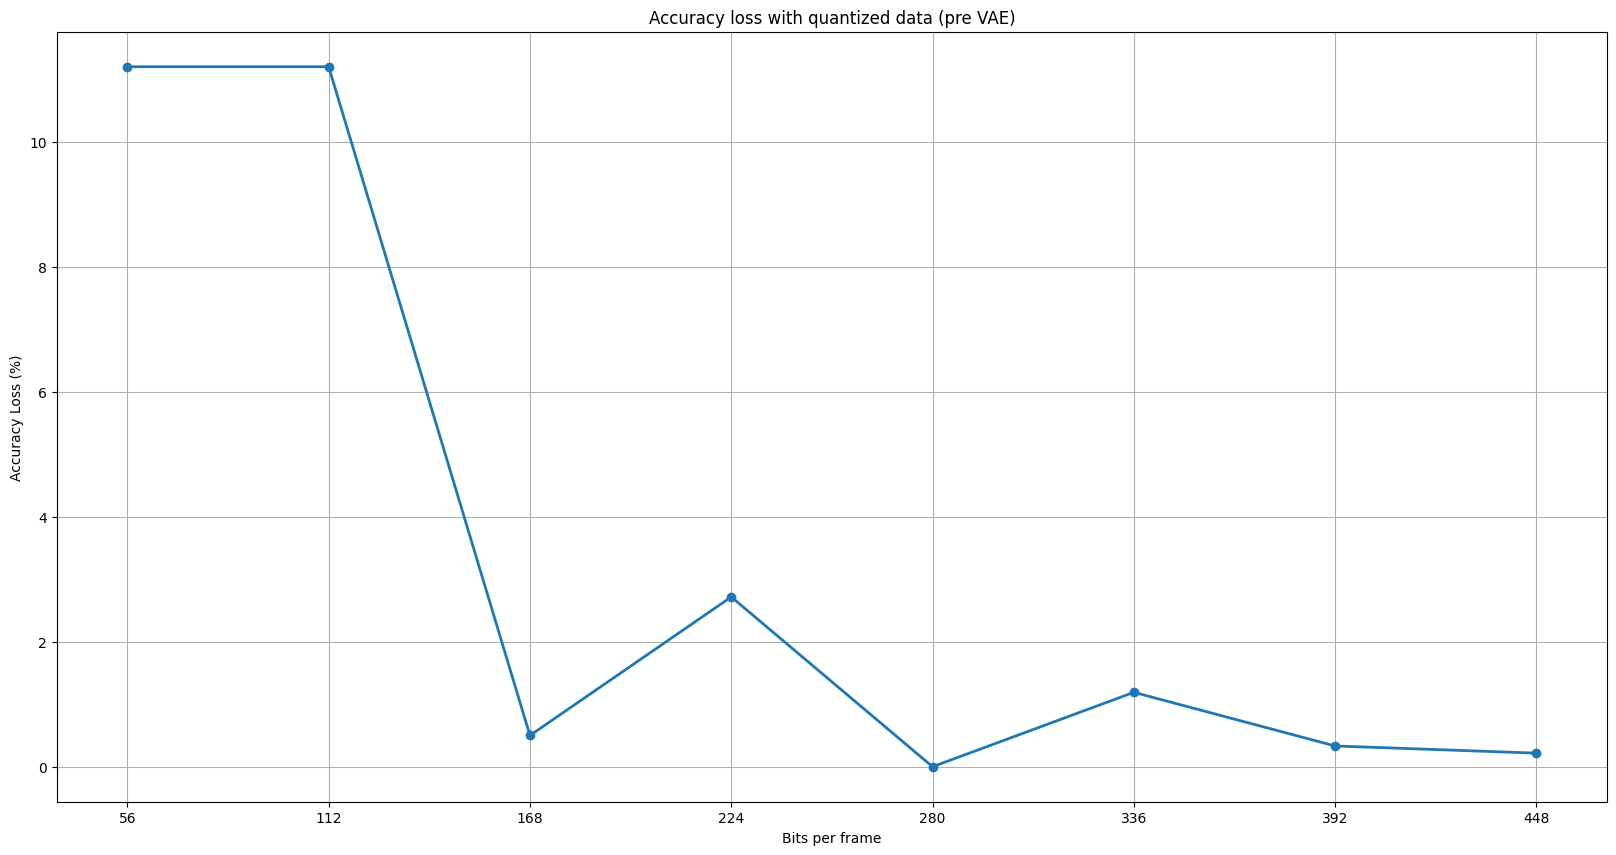

In [47]:
df_VAE_acc_bit = pd.read_csv(f'./results_csv/SQ/QNT_results.csv')

plt.figure(figsize=(20, 10))
plt.plot(df_VAE_acc_bit['QT_frame'], df_VAE_acc_bit['f1_loss'], marker='o', linewidth=2)
plt.title('Accuracy loss with quantized data (pre VAE)')
plt.xlabel('Bits per frame')
plt.xticks(df_VAE_acc_bit['QT_frame'])
plt.ylabel('Accuracy Loss (%)')
plt.grid()
plt.savefig(os.path.join('results_graphs/SQ/accuracy-bit_QNT-Only[BxF].png'))
plt.show()

In [ ]:
df_VAE_acc_bit = pd.read_csv(f'./results_csv/SQ/QNT_results.csv')

plt.figure(figsize=(20, 10))
plt.plot(df_VAE_acc_bit['QT_window'], df_VAE_acc_bit['f1_loss'], marker='o', linewidth=2)
plt.title('Accuracy loss with quantized data (pre VAE)')
plt.xlabel('Bits per window')
plt.xticks(df_VAE_acc_bit['QT_window'])
plt.ylabel('Accuracy Loss (%)')
plt.grid()
plt.savefig(os.path.join('results_graphs/SQ/accuracy-bit_QNT-Only[BxW].png'))
plt.show()

## Vector Quantization

In [119]:
os.makedirs('./results/VQ', exist_ok=True)
os.makedirs('./results_csv/VQ', exist_ok=True)
os.makedirs('./results_graphs/VQ', exist_ok=True)

### VAE Output Quantized

In [70]:
time_window = 3 #seconds
window_size = 32 # for 3 second
step_size = window_size

data = pd.read_csv("../datasets/filteredPresence.csv")
data = data_preprocessing(data, method)
num_features = len(data.columns[1:]) #Excludes the timestamp column (it'll get dropped later)
train_windows, train_labels, test_windows, test_labels = data_windowing(data, time_window, window_size, step_size, verbose=False)
train_data, test_data = CsiData_generator(train_windows, train_labels, test_windows, test_labels, batch_size=window_size, window_size=window_size)

In [ ]:
z_data_train = np.zeros([0, 4])
z_labels_train = np.zeros([0])

vae = VAE(enc_input_shape=(window_size, num_features, 1))
vae.compile(optimizer=tf_keras.optimizers.Adam())
vae.load_weights(f'./models/{folder_name}/train_weights_vae').expect_partial()

z_data_train, z_labels_train = apply_vae_encoder(vae, train_data)
z_data_test, z_labels_test = apply_vae_encoder(vae, test_data)

In [118]:
dumps_directory = f'./dumps/VQ/VAE_QNTZD'
results_directory = f'./results/VQ/VAE_QNTZD'
os.makedirs(dumps_directory, exist_ok=True)

bit_results = []
levels = [2**i for i in range(1, 9)]

labels_train = z_labels_train.copy()
labels_test = z_labels_test.copy()

for lvl in levels:
   print(f"-------------- {lvl} lvls --------------")
   data_train = z_data_train.copy()
   data_test = z_data_test.copy()
   
   train_quantized, codebook = apply_vector_quantization(data_train, lvl) #Vector quantization
   test_quantized = apply_existing_vector_quantization(data_test, codebook)
   
   print(f"DF_QUANTIZED")
   df_test_quantized = pd.DataFrame(test_quantized, columns=['centroid_num'])
   QT_feature, QT_frame, QT_window_feature, QT_window, QT_total = bits_needed(df_test_quantized, window_size, lvl, verbose=True)

   train_quantized = get_quantized_data(train_quantized, codebook)
   test_quantized = get_quantized_data(test_quantized, codebook)

   df_encoded_test, huffman_codes_test = apply_encoding(df_test_quantized)
   print(f"DF_ENCODED")
   ENC_feature, ENC_frame, ENC_window_feature, ENC_window, ENC_total = bits_needed(df_encoded_test, window_size, verbose=True)

   df_train_quantized = pd.DataFrame(train_quantized, columns=[f'z_mean_{i}' for i in range(2)] + [f'z_log_var_{i}' for i in range(2)])
   df_test_quantized = pd.DataFrame(test_quantized, columns=[f'z_mean_{i}' for i in range(2)] + [f'z_log_var_{i}' for i in range(2)])
   data_train = df_train_quantized.to_numpy()
   data_test = df_test_quantized.to_numpy()

   sub_dir=os.path.join(dumps_directory, f'training/{lvl}_lvls.pkl')
   os.makedirs(os.path.dirname(sub_dir), exist_ok=True)
   with open(sub_dir, 'wb') as f:
      pickle.dump([data_train, labels_train], f)

   sub_dir=os.path.join(dumps_directory, f'test/{lvl}_lvls.pkl')
   os.makedirs(os.path.dirname(sub_dir), exist_ok=True)
   with open(sub_dir, 'wb') as f:
      pickle.dump([data_test, labels_test], f)

   bit_results.append({
         'num_levels': lvl,
         'QT_feature': QT_feature,
         'ENC_feature': ENC_feature,
         'QT_frame': QT_frame,
         'ENC_frame': ENC_frame,
         'QT_window': QT_window,
         'ENC_window': ENC_window,
         'QT_total': QT_total,
         'ENC_total': ENC_total
      })

bit_results = pd.DataFrame(bit_results)
bit_results.to_csv(f'./results_csv/VQ/VAE_bits.csv', index=False)

-------------- 2 lvls --------------
DF_QUANTIZED
Number of windows: 1179
Bits needed per feature: 1 bits
Bits needed per frame: 1 bits
Bits needed per feature per window: 32 bits
Bits needed per window: 32 bits
Total bits needed for the dataset: 37728 bits
DF_ENCODED
Number of windows: 1179
Average bits needed per feature: 0.05 bits
Average bits needed per frame per window: 0.05 bits
Average bits needed per feature per window: 1.68 bits
Average bits needed per window: 1.68 bits
Total bits needed for the dataset: 1984.0 bits
-------------- 4 lvls --------------
DF_QUANTIZED
Number of windows: 1179
Bits needed per feature: 2 bits
Bits needed per frame: 2 bits
Bits needed per feature per window: 64 bits
Bits needed per window: 64 bits
Total bits needed for the dataset: 75456 bits
DF_ENCODED
Number of windows: 1179
Average bits needed per feature: 0.33 bits
Average bits needed per frame per window: 0.33 bits
Average bits needed per feature per window: 10.69 bits
Average bits needed per wi

In [ ]:
dumps_directory = f'./dumps/VQ/VAE_QNTZD'
results_directory = f'./results/VQ/VAE_QNTZD'
levels = [2**i for i in range(1, 9)]
results = []

for lvl in levels:  
    print(f"-------------- {lvl} lvls --------------")
    train_dump_dir = f'./dumps/benchmark/training/benchmark.pkl'
    test_dump_dir=os.path.join(dumps_directory, f'test/{lvl}_lvls.pkl')

    # Test model
    f1_result = results_test(train_dump_dir, test_dump_dir, num_levels=lvl)
    results.append(
        {
            "num_levels": lvl,
            "f1_score": f1_result
        })
        
results_df = pd.DataFrame(results)
os.makedirs('results_csv', exist_ok=True)
results_df.to_csv('results_csv/VQ/VAE_accuracy.csv', index=False)

#### Graphs

In [40]:
df_VAE_f1 = pd.read_csv('results_csv/VQ/VAE_accuracy.csv')
df_VAE_f1 = f1_loss(df_VAE_f1, max_score)
df_VAE_bits = pd.read_csv('results_csv/VQ/VAE_bits.csv')
df_VAE_f1_bits = pd.merge(df_VAE_f1, df_VAE_bits, on=['num_levels'])

df_VAE_f1_bits.to_csv(f'./results_csv/VQ/VAE_results.csv', index=False)

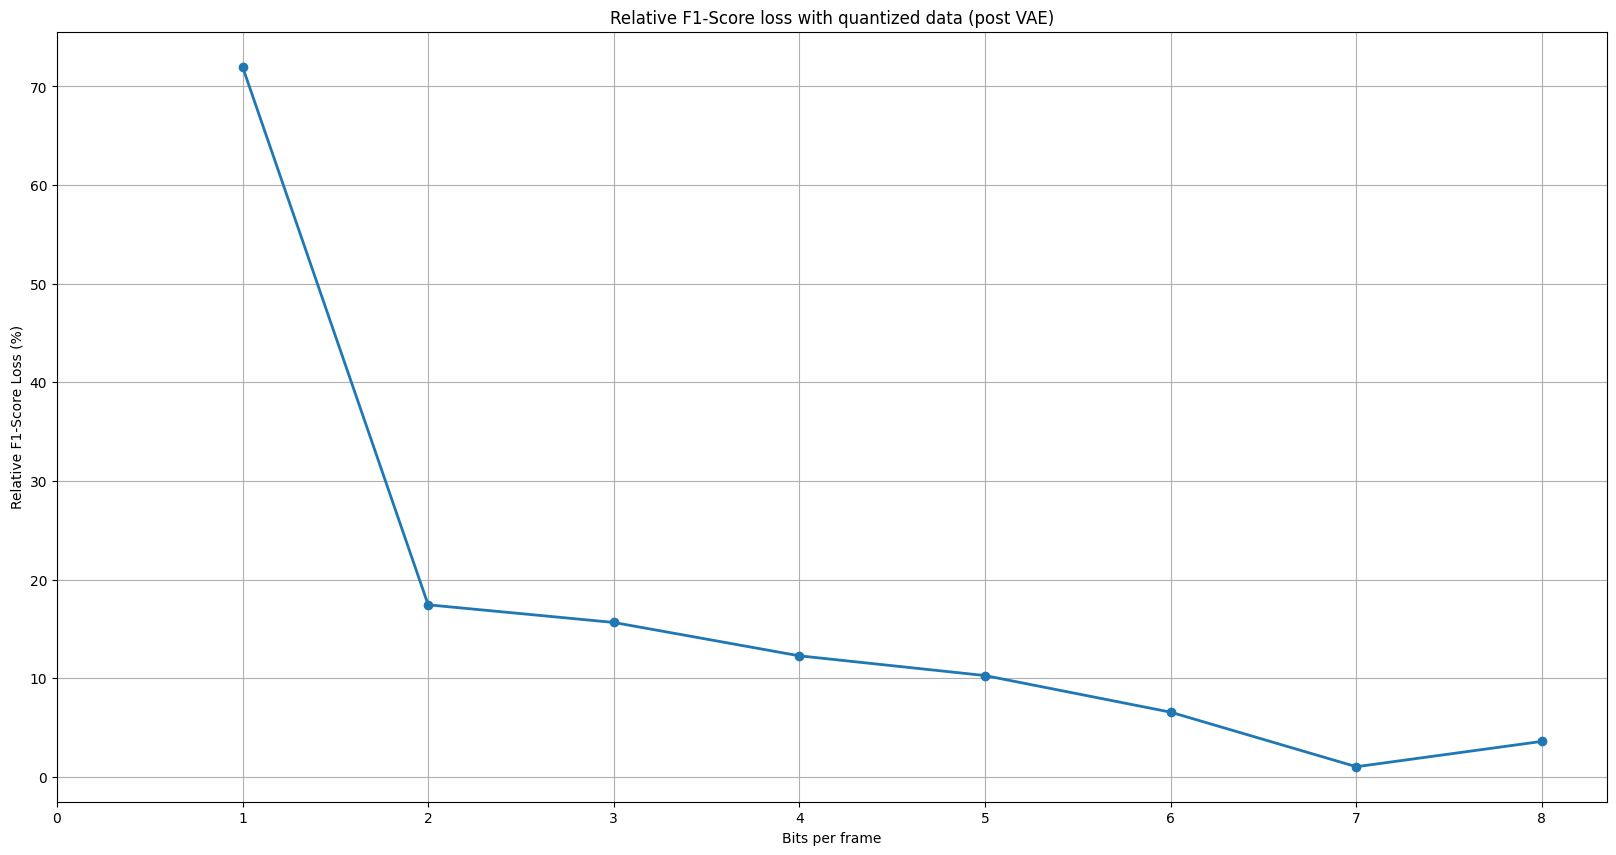

In [44]:
df_VAE_f1_bits = pd.read_csv(f'./results_csv/VQ/VAE_results.csv')

plt.figure(figsize=(20, 10))
plt.plot(df_VAE_f1_bits['QT_frame'], df_VAE_f1_bits['f1_loss'], marker='o', linewidth=2)
plt.title('Relative F1-Score loss with quantized data (post VAE)')
plt.xlabel('Bits per frame')
plt.xticks(np.arange(0, 9, 1))
plt.ylabel('Relative F1-Score Loss (%)')
plt.grid()
plt.savefig(os.path.join('results_graphs/VQ/accuracy-bit_POST-VAE[BxF].png'))
plt.show()

In [ ]:
df_VAE_f1_bits = pd.read_csv(f'./results_csv/VQ/VAE_results.csv')

plt.figure(figsize=(20, 10))
plt.plot(df_VAE_f1_bits['QT_window'], df_VAE_f1_bits['f1_loss'], marker='o', linewidth=2)
plt.title('Relative F1-Score loss with quantized data (post VAE)')
plt.xlabel('Bits per window')
plt.xticks(np.arange(0, 1500, 100))
plt.ylabel('Relative F1-Score Loss (%)')
plt.grid()
plt.savefig(os.path.join('results_graphs/VQ/accuracy-bit_POST-VAE[BxW].png'))
plt.show()

### Comprehensive Run

In [42]:
#components = [i for i in range(1, 10)] + [i for i in range (10, 20, 2)] + [i for i in range(20, 35, 5)] + [40]
components = [2, 4, 8, 16]
levels = [2**i for i in range(1, 9)]

time_window = 3 #seconds
window_size = 32 # for 3 second
step_size = window_size

data = pd.read_csv("../datasets/filteredPresence.csv")
data = data_preprocessing(data, method)
csi_subcarriers = data.columns[1:]
num_features = len(data.columns[1:]) #Excludes the timestamp column (it'll get dropped later)

train_windows, train_labels, test_windows, test_labels = data_windowing(data, time_window, window_size, step_size, verbose=False)
train_data, test_data = CsiData_generator(train_windows, train_labels, test_windows, test_labels, batch_size=window_size, window_size=window_size)

In [ ]:
results_directory = './results/VQ'
df_csi_train = pd.DataFrame(train_data.csi.numpy(), columns=csi_subcarriers)
df_csi_test = pd.DataFrame(test_data.csi.numpy(), columns=csi_subcarriers)

results = []
x = 2
x = x/0

for num_components in components:
    print(f"-------------- {num_components} components --------------")
    df_train = df_csi_train.copy()
    df_test = df_csi_test.copy()
    dumps_directory = f'./dumps/VQ/{num_components}_components'
    os.makedirs(dumps_directory, exist_ok=True)

    #Apply PCA
    df_train_reduced, pca = analyze_PCA(df_train, num_components, directory=dumps_directory, saveGraph=True, plotGraph=True)
    test_reduced = pca.transform(df_test)
    df_test_reduced = pd.DataFrame(test_reduced, columns=[f'PC{i}' for i in range(num_components)])

    for num_levels in levels:
        print(f"-------------- {num_components} components w/ {num_levels} lvls --------------")
        filename = f'{num_levels}_lvls'
        
        train_quantized, codebook = apply_vector_quantization(df_train_reduced, num_levels) #Vector quantization
        test_quantized = apply_existing_vector_quantization(df_test_reduced, codebook)
        
        train_quantized = get_quantized_data(train_quantized, codebook)
        test_quantized = get_quantized_data(test_quantized, codebook)

        df_train_quantized = pd.DataFrame(train_quantized, columns=[f'PC{i}' for i in range(num_components)])
        df_test_quantized = pd.DataFrame(test_quantized, columns=[f'PC{i}' for i in range(num_components)])

        #Reconstruct the data
        df_train_reconstructed = reconstruct_data(df_train_quantized, pca, csi_subcarriers)
        df_train_reconstructed = df_train_reconstructed.to_numpy()
        reconstructed_train_data = tf.convert_to_tensor(df_train_reconstructed, dtype=tf.float32)
        train_data.csi = reconstructed_train_data

        df_test_reconstructed = reconstruct_data(df_test_quantized, pca, csi_subcarriers)
        df_test_reconstructed = df_test_reconstructed.to_numpy()
        reconstructed_test_data = tf.convert_to_tensor(df_test_reconstructed, dtype=tf.float32)
        test_data.csi = reconstructed_test_data

        vae = VAE(enc_input_shape=(window_size, num_features, 1))
        vae.compile(optimizer=tf_keras.optimizers.Adam())
        vae.load_weights(f'./models/{folder_name}/train_weights_vae').expect_partial()
        
        print("Encoding train data...")
        z_data_train, z_labels_train = apply_vae_encoder(vae, train_data)
        
        print("Encoding test data...")
        z_data_test, z_labels_test = apply_vae_encoder(vae, test_data)

        train_dump_dir=os.path.join(dumps_directory, f'training/{filename}.pkl')
        os.makedirs(os.path.dirname(train_dump_dir), exist_ok=True)
        test_dump_dir=os.path.join(dumps_directory, f'test/{filename}.pkl')
        os.makedirs(os.path.dirname(test_dump_dir), exist_ok=True)
        print("Saving data...")
        with open(train_dump_dir, 'wb') as f:
            pickle.dump([z_data_train, z_labels_train], f)
        with open(test_dump_dir, 'wb') as f:
            pickle.dump([z_data_test, z_labels_test], f)

print("Done")

In [ ]:
#components = [i for i in range(1, 10)] + [i for i in range (10, 20, 2)] + [i for i in range(20, 35, 5)] + [40]
components = [2, 4, 8, 16]
levels = [2**i for i in range(1, 9)]

for num_components in components:
    dumps_directory = f'./dumps/VQ/{num_components}_components'
    for num_levels in levels:
        test_dump_dir=os.path.join(dumps_directory, f'test/{num_levels}_lvls.pkl')
        with open (test_dump_dir, 'rb') as f:
            z_data_train, z_labels_train= pickle.load(f)

        plt.figure(figsize=(20, 10))
        for i in range(len(z_data_train)):
            plt.plot(z_data_train[i][0], z_data_train[i][1], marker='o', color='blue' if z_labels_train[i] == 0 else 'green')
        plt.title(f'Distribution of data with {num_components} components and {num_levels} levels')
        plt.xlabel('Mean')
        plt.ylabel('Variance')
        plt.legend()
        plt.grid()
        plt.show()

In [ ]:
#components = [i for i in range(1, 10)] + [i for i in range (10, 20, 2)] + [i for i in range(20, 35, 5)] + [40]
components = [2, 4, 8, 16]
levels = [2**i for i in range(1, 9)]

results_directory = './results/VQ'
results = []
for num_components in components:
    dumps_directory = f'./dumps/VQ/{num_components}_components'
    for num_levels in levels:  
        print(f"-------------- {num_components} components w/ {num_levels} lvls --------------")
        train_dump_dir = f'./dumps/benchmark/training/benchmark.pkl'
        test_dump_dir=os.path.join(dumps_directory, f'test/{num_levels}_lvls.pkl')

        # Test model
        f1_result = results_test(train_dump_dir, test_dump_dir, num_components, num_levels)
        results.append(
            {
                "num_components": num_components,
                "num_levels": num_levels,
                "f1_score": f1_result
            })
        
results_df = pd.DataFrame(results)
results_df.to_csv('./results_csv/VQ/accuracy.csv', index=False)

#### Bits

In [46]:
components = [i for i in range(1, 10)] + [i for i in range (10, 20, 2)] + [i for i in range(20, 35, 5)] + [40]
#components = [2, 4, 8, 16]
levels = [2**i for i in range(1, 9)]
time_window = 3 #seconds
window_size = 64 # for 3 second
step_size = window_size // 2

data = pd.read_csv("../datasets/filteredPresence.csv")
data = data_preprocessing(data, method)
csi_subcarriers = data.columns[1:]
num_features = len(csi_subcarriers)

train_windows, train_labels, test_windows, test_labels = data_windowing(data, time_window, window_size, step_size, verbose=False)
train_data, test_data = CsiData_generator(train_windows, train_labels, test_windows, test_labels, window_size, step_size)

df_csi_train = pd.DataFrame(train_data.csi.numpy(), columns=csi_subcarriers)
df_csi_test = pd.DataFrame(test_data.csi.numpy(), columns=csi_subcarriers)

results_directory = './results/VQ'
bit_results = []

for num_components in components:
    print(f"-------------- {num_components} components ----------------------")
    df_train = df_csi_train.copy()
    df_test = df_csi_test.copy()
    dumps_directory = f'./dumps/VQ/{num_components}_components'

    #Apply PCA
    df_train_reduced, pca = analyze_PCA(df_train, num_components, directory=dumps_directory, plotGraph=False)

    test_reduced = pca.transform(df_test)
    df_test_reduced = pd.DataFrame(test_reduced, columns=[f'PC{i}' for i in range(num_components)])
    
    print (f"DF_CSI_DATA")
    PCA_feature, PCA_frame, PCA_window_feature, PCA_window, PCA_total = bits_needed(df_test_reduced, window_size, verbose=True)

    for num_levels in levels:
        print(f"-------------- {num_components} components {num_levels} lvls --------------")

        #Quantize the data
        train_quantized, codebook = apply_vector_quantization(df_train_reduced, num_levels) #Vector quantization
        test_quantized = apply_existing_vector_quantization(df_test_reduced, codebook)
        
        print (f"DF_QUANTIZED")
        df_test_quantized = pd.DataFrame(test_quantized, columns=['centroid_num'])
        QT_feature, QT_frame, QT_window_feature, QT_window, QT_total = bits_needed(df_test_quantized, window_size, num_levels, verbose=True)

        #Huffman
        df_encoded_test, huffman_codes_test = apply_encoding(df_test_quantized)
        print (f"DF_ENCODED")
        ENC_feature, ENC_frame, ENC_window_feature, ENC_window, ENC_total = bits_needed(df_encoded_test, window_size, verbose=True)
        enc_entropy = compute_entropy(df_encoded_test, verbose=False)
        print(f"Entropy of encoded data: {enc_entropy} bits")

        #Reconstruct the data
        test_quantized = get_quantized_data(test_quantized, codebook)
        df_test_quantized = pd.DataFrame(test_quantized, columns=[f'PC{i}' for i in range(num_components)])
        df_test_reconstructed = reconstruct_data(df_test_quantized, pca, csi_subcarriers)
        print (f"DF_RECONSTRUCTED")
        REC_feature, REC_frame, REC_window_feature, REC_window, REC_total = bits_needed(df_test_reconstructed, window_size, verbose=True)
        
        df_test_reconstructed = df_test_reconstructed.to_numpy()
        reconstructed_test_data = tf.convert_to_tensor(df_test_reconstructed)
        test_data.csi = reconstructed_test_data

        bit_results.append({
            'num_components': num_components,
            'num_levels': num_levels,
            'PCA_feature': PCA_feature,
            'QT_feature': QT_feature,
            'ENC_feature': ENC_feature,
            'REC_feature': REC_feature,
            'PCA_frame': PCA_frame,
            'QT_frame': QT_frame,
            'ENC_frame': ENC_frame,
            'REC_frame': REC_frame,
            'QT_window': QT_window,
            'PCA_window': PCA_window,
            'ENC_window': ENC_window,
            'REC_window': REC_window,
            'PCA_total': PCA_total,
            'QT_total': QT_total,
            'ENC_total': ENC_total,
            'REC_total': REC_total
        })

bit_results = pd.DataFrame(bit_results)
bit_results.to_csv(f'./results_csv/VQ/bits.csv', index=False)

-------------- 1 components ----------------------
Explained variance ratio: [0.6396707]
Final Cumulative Explained Variance: 0.6396707
DF_CSI_DATA
Number of windows: 231
Average bits needed per feature: 6.0 bits
Average bits needed per frame per window: 6.0 bits
Average bits needed per feature per window: 384.0 bits
Average bits needed per window: 384.0 bits
Total bits needed for the dataset: 88704.0 bits
-------------- 1 components 2 lvls --------------
DF_QUANTIZED
Number of windows: 231
Bits needed per feature: 1 bits
Bits needed per frame: 1 bits
Bits needed per feature per window: 64 bits
Bits needed per window: 64 bits
Total bits needed for the dataset: 14784 bits
DF_ENCODED
Number of windows: 231
Average bits needed per feature: 0.23 bits
Average bits needed per frame per window: 0.23 bits
Average bits needed per feature per window: 14.96 bits
Average bits needed per window: 14.96 bits
Total bits needed for the dataset: 3456.0 bits
Entropy of encoded data: 0.9 bits
DF_RECONSTRU

#### Graphs

In [47]:
components = [i for i in range(1, 10)] + [i for i in range (10, 20, 2)] + [i for i in range(20, 35, 5)] + [40]
levels = [2**i for i in range(1, 9)]

In [48]:
#merge csv
df_f1 = pd.read_csv('results_csv/VQ/accuracy.csv')
df_f1 = f1_loss(df_f1, max_score)
df_bits = pd.read_csv('results_csv/VQ/bits.csv')
df_f1_bit = pd.merge(df_f1, df_bits, on=['num_components', 'num_levels'])
df_f1_bit.to_csv(f'./results_csv/VQ/results.csv', index=False)

df_VAE_f1 = pd.read_csv('results_csv/VQ/VAE_accuracy.csv')
df_VAE_f1 = f1_loss(df_VAE_f1, max_score)
df_VAE_bits = pd.read_csv('results_csv/VQ/VAE_bits.csv')
df_VAE_f1_bits = pd.merge(df_VAE_f1, df_VAE_bits, on=['num_levels'])

df_VAE_f1_bits.to_csv(f'./results_csv/VQ/VAE_results.csv', index=False)

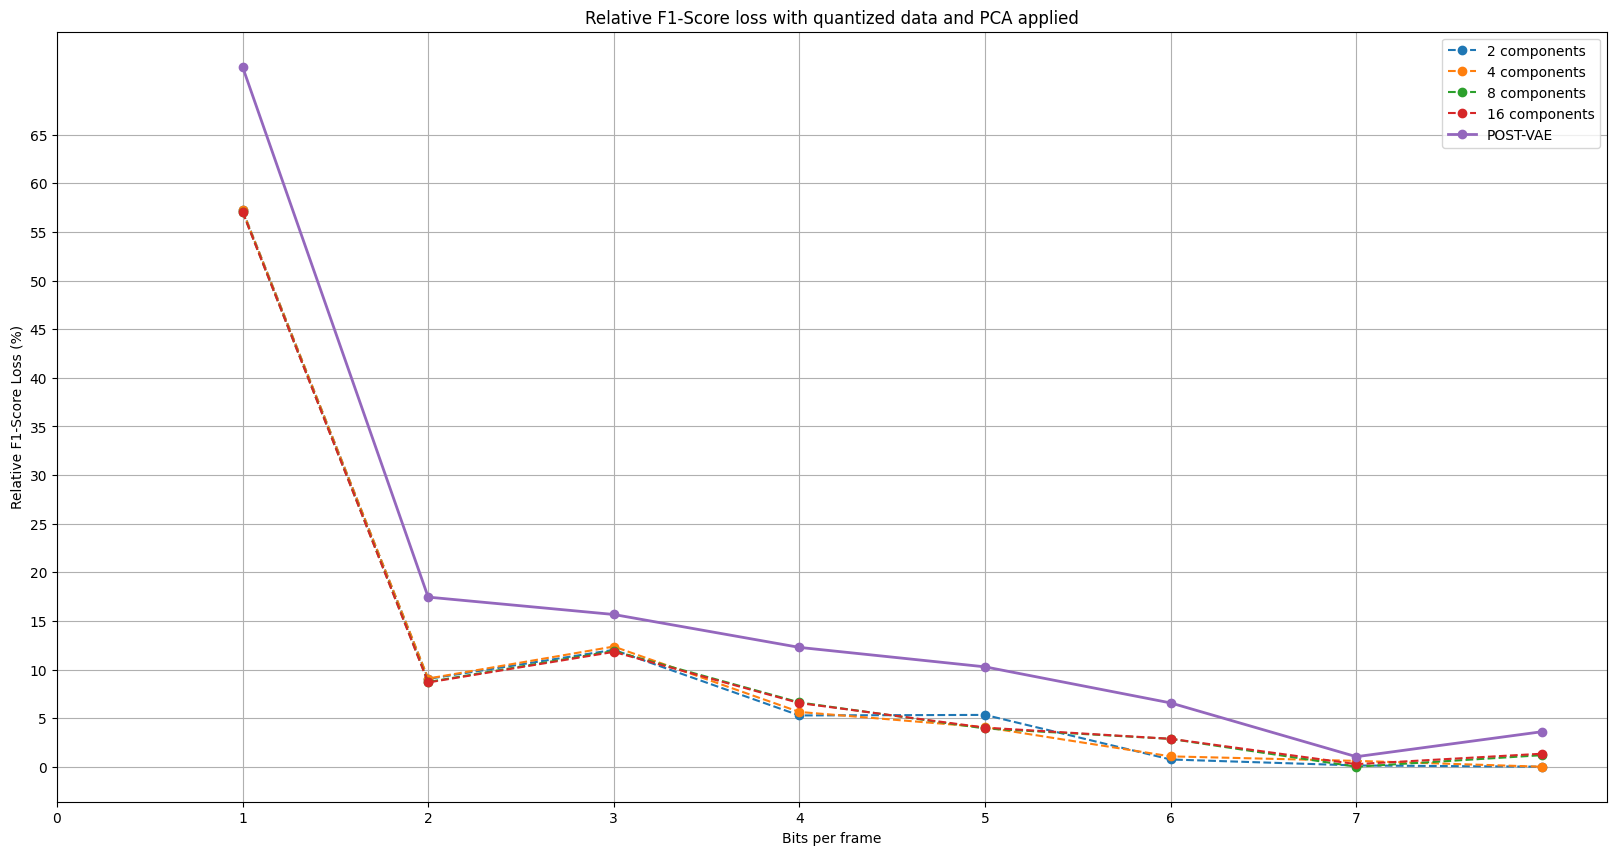

In [53]:
df_f1_bit = pd.read_csv(f'./results_csv/VQ/results.csv')
df_VAE_f1_bits = pd.read_csv(f'./results_csv/VQ/VAE_results.csv')

components = [2, 4, 8, 16]

plt.figure(figsize=(20, 10))
for num_components in df_f1_bit['num_components'].unique():
    if num_components not in components:
        continue
    target_data = df_f1_bit[df_f1_bit['num_components'] == num_components]
    plt.plot(target_data['QT_frame'], target_data['f1_loss'], marker='o', linestyle='--', label=f'{num_components} components')
plt.plot(df_VAE_f1_bits['QT_frame'], df_VAE_f1_bits['f1_loss'], marker='o', label='POST-VAE', linewidth=2)
plt.title('Relative F1-Score loss with quantized data and PCA applied')
plt.xticks(np.arange(0, 8, 1))
plt.xlabel('Bits per frame')
plt.yticks(np.arange(0, 70, 5))
plt.ylabel('Relative F1-Score Loss (%)')
plt.legend()
plt.grid()
plt.savefig(os.path.join('results_graphs/VQ/accuracy-bit[BxF].png'))
plt.show()

In [ ]:
df_f1_bit = pd.read_csv(f'./results_csv/VQ/results.csv')
df_VAE_f1_bits = pd.read_csv(f'./results_csv/VQ/VAE_results.csv')

plt.figure(figsize=(20, 10))
for num_components in df_f1_bit['num_components'].unique():
    if num_components not in components:
        continue
    target_data = df_f1_bit[df_f1_bit['num_components'] == num_components]
    plt.plot(target_data['QT_window'], target_data['f1_loss'], marker='o', linestyle='--', label=f'{num_components} components')
plt.plot(df_VAE_f1_bits['QT_window'], df_VAE_f1_bits['f1_loss'], marker='o', label='POST-VAE', linewidth=2)
plt.title('Relative F1-Score loss with quantized data and PCA applied')
plt.xlabel('Bits per window')
plt.xticks(np.arange(0, 1800, 100))
plt.ylabel('Relative F1-Score Loss (%)')
plt.yticks(np.arange(0, 70, 5))
plt.legend()
plt.grid()
plt.savefig(os.path.join('results_graphs/VQ/accuracy-bit[BxW].png'))
plt.show()

In [ ]:
df_f1_bit = pd.read_csv(f'./results_csv/VQ/results.csv')
df_VAE_f1_bits = pd.read_csv(f'./results_csv/VQ/VAE_results.csv')

plt.figure(figsize=(20, 10))
for num_components in df_f1_bit['num_components'].unique():
    if num_components not in components:
        continue
    target_data = df_f1_bit[df_f1_bit['num_components'] == num_components]
    plt.plot(target_data['ENC_frame'], target_data['f1_loss'], marker='o', linestyle='--', label=f'{num_components} components')
plt.title('Relative F1-Score loss with quantized and encoded data and PCA applied')
plt.xlabel('Average bits per frame')
plt.xticks(np.arange(0, 7, 1))
plt.ylabel('Relative F1-Score Loss (%)')
plt.yticks(np.arange(0, 70, 5))
plt.legend()
plt.grid()
plt.savefig(os.path.join('results_graphs/VQ/accuracy-bit_Encoded[BxF].png'))
plt.show()

In [ ]:
df_f1_bit = pd.read_csv(f'./results_csv/VQ/results.csv')
df_VAE_f1_bits = pd.read_csv(f'./results_csv/VQ/VAE_results.csv')

plt.figure(figsize=(20, 10))
for num_components in df_f1_bit['num_components'].unique():
    if num_components not in components:
        continue
    target_data = df_f1_bit[df_f1_bit['num_components'] == num_components]
    plt.plot(target_data['ENC_window'], target_data['f1_loss'], marker='o', linestyle='--', label=f'{num_components} components')
plt.title('Relative F1-Score loss with quantized and encoded data and PCA applied')
plt.xlabel('Average bits per window')
plt.xticks(np.arange(0, 1450, 50))
plt.ylabel('Relative F1-Score Loss (%)')
plt.yticks(np.arange(0, 70, 5))
plt.legend()
plt.grid()
plt.savefig(os.path.join('results_graphs/VQ/accuracy-bit_Encoded[BxW].png'))
plt.show()

In [ ]:
components = [i for i in range(1, 10)] + [i for i in range (10, 20, 2)] + [i for i in range(20, 35, 5)] + [40]
levels = [2**i for i in range(1, 9)]
df_f1_bit = pd.read_csv(f'./results_csv/VQ/results.csv')

plt.figure(figsize=(20, 10))
for lvl in df_f1_bit['num_levels'].unique():
    target_data = df_f1_bit[df_f1_bit['num_levels'] == lvl]

    original_bits = target_data['QT_window']
    huffman_bits = target_data['ENC_window']

    saved_space_percentage = [(orig - huff) / orig * 100 for orig, huff in zip(original_bits, huffman_bits)]
    # Plotting
    plt.plot(components, saved_space_percentage, marker='o', linestyle='--', label=f'{lvl} levels')
plt.xlabel('Number of components')
plt.xticks(components)
plt.ylabel('Saved Space (%)')
plt.title('Percentage of saved space per window with encoded data versus non-encoded data (quantized data with PCA applied)')
plt.grid(True)
plt.legend(loc="lower right")
#plt.savefig(os.path.join('results_graphs/VQ/saved_space_percentage[QT-ENC].png'))
plt.show()


In [ ]:
components = [i for i in range(1, 10)] + [i for i in range (10, 20, 2)] + [i for i in range(20, 35, 5)] + [40]
levels = [2**i for i in range(1, 9)]
df_f1_bit = pd.read_csv(f'./results_csv/VQ/results.csv')

plt.figure(figsize=(20, 10))
for lvl in df_f1_bit['num_levels'].unique():
    target_data = df_f1_bit[df_f1_bit['num_levels'] == lvl]

    original_bits = target_data['PCA_window']
    huffman_bits = target_data['ENC_window']

    saved_space_percentage = [(orig - huff) / orig * 100 for orig, huff in zip(original_bits, huffman_bits)]
    # Plotting
    plt.plot(components, saved_space_percentage, marker='o', linestyle='--', label=f'{lvl} levels')
plt.xlabel('Number of components')
plt.xticks(components)
plt.ylabel('Saved Space (%)')
plt.title('Percentage of saved space per window with encoded data versus non-encoded PCA data')
plt.grid(True)
plt.legend(loc="lower right")
#plt.savefig(os.path.join('results_graphs/VQ/saved_space_percentage[PCA-ENC].png'))
plt.show()


### VAE Input Quantized

In [124]:
levels = [2**i for i in range(1, 9)]

time_window = 3 #seconds
window_size = 32 # for 3 second
step_size = window_size

data = pd.read_csv("../datasets/filteredPresence.csv")
data = data_preprocessing(data, method)
csi_subcarriers = data.columns[1:]
num_features = len(data.columns[1:]) #Excludes the timestamp column (it'll get dropped later)

train_windows, train_labels, test_windows, test_labels = data_windowing(data, time_window, window_size, step_size, verbose=False)
train_data, test_data = CsiData_generator(train_windows, train_labels, test_windows, test_labels, batch_size=window_size, window_size=window_size)

In [ ]:
results_directory = './results/VQ/QNT_Only'
dumps_directory = f'./dumps/VQ/QNT_Only'
os.makedirs(results_directory, exist_ok=True)
os.makedirs(dumps_directory, exist_ok=True)
df_csi_train = pd.DataFrame(train_data.csi.numpy(), columns=csi_subcarriers)
df_csi_test = pd.DataFrame(test_data.csi.numpy(), columns=csi_subcarriers)
results = []

for num_levels in levels:
    print(f"-------------- {num_levels} lvls --------------")
    df_train = df_csi_train.copy()
    df_test = df_csi_test.copy()

    train_quantized, codebook = apply_vector_quantization(df_train, num_levels) #Vector quantization
    test_quantized = apply_existing_vector_quantization(df_test, codebook)

    print (f"DF_QUANTIZED")
    df_test_quantized_bits = pd.DataFrame(test_quantized, columns=['centroid_num'])
    QT_feature, QT_frame, QT_window_feature, QT_window, QT_total = bits_needed(df_test_quantized_bits, window_size, num_levels, verbose=True)

    train_quantized = get_quantized_data(train_quantized, codebook)
    test_quantized = get_quantized_data(test_quantized, codebook)

    df_train_quantized = pd.DataFrame(train_quantized, columns=csi_subcarriers)
    df_test_quantized = pd.DataFrame(test_quantized, columns=csi_subcarriers)

    train_qntz_data =tf.convert_to_tensor(df_train_quantized.to_numpy(), dtype=tf.float32)
    test_qntz_data = tf.convert_to_tensor(df_test_quantized.to_numpy(), dtype=tf.float32)

    train_data.csi = train_qntz_data
    test_data.csi = test_qntz_data

    df_encoded_test, huffman_codes_test = apply_encoding(df_test_quantized)
    print(f"DF_ENCODED")
    ENC_feature, ENC_frame, ENC_window_feature, ENC_window, ENC_total = bits_needed(df_encoded_test, window_size, verbose=True)


    vae = VAE(enc_input_shape=(window_size, num_features, 1))
    vae.compile(optimizer=tf_keras.optimizers.Adam())
    vae.load_weights(f'./models/{folder_name}/train_weights_vae').expect_partial()

    print("Encoding train data...")
    z_data_train, z_labels_train = apply_vae_encoder(vae, train_data)

    print("Encoding test data...")
    z_data_test, z_labels_test = apply_vae_encoder(vae, test_data)

    train_dump_dir=os.path.join(dumps_directory, f'training/{num_levels}_lvls.pkl')
    os.makedirs(os.path.dirname(train_dump_dir), exist_ok=True)
    test_dump_dir=os.path.join(dumps_directory, f'test/{num_levels}_lvls.pkl')
    os.makedirs(os.path.dirname(test_dump_dir), exist_ok=True)
    print("Saving data...")
    with open(train_dump_dir, 'wb') as f:
        pickle.dump([z_data_train, z_labels_train], f)
    with open(test_dump_dir, 'wb') as f:
        pickle.dump([z_data_test, z_labels_test], f)

    results.append({
            'num_levels': num_levels,
            'QT_feature': QT_feature,
            'ENC_feature': ENC_feature,
            'QT_frame': QT_frame,
            'ENC_frame': ENC_frame,
            'QT_window': QT_window,
            'ENC_window': ENC_window,
            'QT_total': QT_total,
            'ENC_total': ENC_total
        })

results = pd.DataFrame(results)
results.to_csv(f'./results_csv/VQ/QNT_bits.csv', index=False)
print("Done")

-------------- 2 lvls --------------
DF_QUANTIZED
Number of windows: 1180
Bits needed per feature: 1 bits
Bits needed per frame: 56 bits
Bits needed per feature per window: 32 bits
Bits needed per window: 1792 bits
Total bits needed for the dataset: 2114560 bits
DF_ENCODED
Number of windows: 1180
Average bits needed per feature: 0.1 bits
Average bits needed per frame per window: 5.81 bits
Average bits needed per feature per window: 3.32 bits
Average bits needed per window: 186.03 bits
Total bits needed for the dataset: 219520.0 bits
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_41 (InputLayer)       [(None, 32, 56, 1)]          0         []                            
                                                                                                  
 conv2d_40 (Conv2D)          (None, 30, 54, 64) 

In [ ]:
results_directory = './results/VQ/QNT_Only'
levels = [2**i for i in range(1, 9)]
results = []


dumps_directory = f'./dumps/VQ/QNT_Only'
for num_levels in levels:  
    print(f"-------------- {num_levels} lvls --------------")
    train_dump_dir = f'./dumps/benchmark/training/benchmark.pkl'
    test_dump_dir=os.path.join(dumps_directory, f'test/{num_levels}_lvls.pkl')

    # Test model
    f1_result = results_test(train_dump_dir, test_dump_dir, num_levels=num_levels)
    results.append(
        {
            "num_levels": num_levels,
            "f1_score": f1_result
        })
        
results_df = pd.DataFrame(results)
results_df.to_csv('./results_csv/VQ/QNT_accuracy.csv', index=False)

#### Graphs

In [51]:
df_VAE_accuracy = pd.read_csv('results_csv/VQ/QNT_accuracy.csv')
df_VAE_accuracy = f1_loss(df_VAE_accuracy, max_score)
df_VAE_bits = pd.read_csv('results_csv/VQ/QNT_bits.csv')
df_VAE_acc_bit = pd.merge(df_VAE_accuracy, df_VAE_bits, on=['num_levels'])

df_VAE_acc_bit.to_csv(f'./results_csv/VQ/QNT_results.csv', index=False)

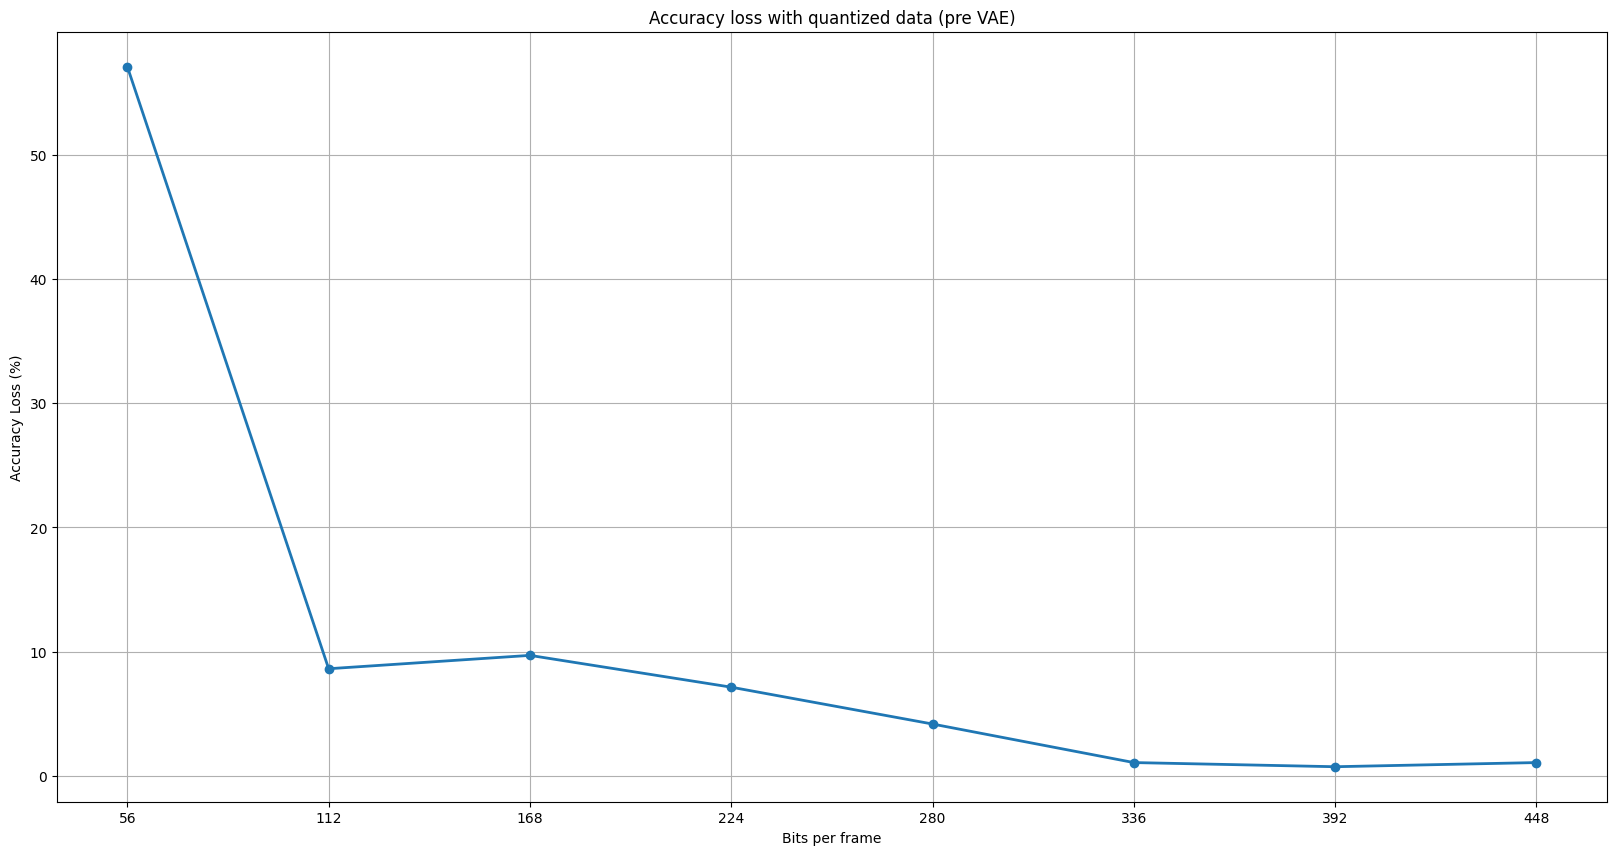

In [54]:
df_VAE_acc_bit = pd.read_csv(f'./results_csv/VQ/QNT_results.csv')

plt.figure(figsize=(20, 10))
plt.plot(df_VAE_acc_bit['QT_frame'], df_VAE_acc_bit['f1_loss'], marker='o', linewidth=2)
plt.title('Accuracy loss with quantized data (pre VAE)')
plt.xlabel('Bits per frame')
plt.xticks(df_VAE_acc_bit['QT_frame'])
plt.ylabel('Accuracy Loss (%)')
plt.grid()
#plt.savefig(os.path.join('results_graphs/VQ/accuracy-bit_QNT-Only[BxF].png'))
plt.show()

In [ ]:
df_VAE_acc_bit = pd.read_csv(f'./results_csv/VQ/QNT_results.csv')

plt.figure(figsize=(20, 10))
plt.plot(df_VAE_acc_bit['QT_window'], df_VAE_acc_bit['f1_loss'], marker='o', linewidth=2)
plt.title('Accuracy loss with quantized data (pre VAE)')
plt.xlabel('Bits per window')
plt.xticks(df_VAE_acc_bit['QT_window'])
plt.ylabel('Accuracy Loss (%)')
plt.grid()
plt.savefig(os.path.join('results_graphs/VQ/accuracy-bit_QNT-Only[BxW].png'))
plt.show()